In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <b style="background-color:#e35b89; padding:5px; border-radius:5px; display: inline-block;">Multiclass Image Classification</b>



### <b style="background-color:#e35b89; padding:5px; border-radius:5px; display: inline-block;">Imports</b>


In [ ]:
# --- Standard Libraries ---
import os
import shutil
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, subplots, show
from pathlib import Path

# --- Scikit-learn ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    classification_report,
    accuracy_score
)

# --- TensorFlow & Keras Core ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import (
    CategoricalAccuracy,
    AUC,
    F1Score
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
    CSVLogger,
    LearningRateScheduler
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory

# --- Keras Optimizers & Metrics ---
from keras.optimizers import AdamW
from keras.metrics import (
    Precision,
    Recall,
    AUC,
    TopKCategoricalAccuracy,
    F1Score
)

# --- Keras Layers ---
from tensorflow.keras.layers import (
    add,
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Activation,
    GlobalAveragePooling2D,
    Rescaling,
    RandomFlip,
    RandomRotation,
    RandomZoom,
    RandomContrast,
    RandomSharpness,
    RandomBrightness,
    RandomSaturation,
    RandAugment
)

from keras.layers import LeakyReLU  # Optional (only if used)
from keras.regularizers import l2

# --- Keras Applications ---
from tensorflow.keras.applications import (
    DenseNet121,
    InceptionResNetV2,
    ConvNeXtBase
)
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.convnext import preprocess_input as preprocess_convnext


import pickle

# --- Keras Tuner ---

from keras_tuner.tuners import RandomSearch
from keras_tuner import HyperModel
from keras_tuner import Objective

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/dl_run')

import library
from library import *

### <b style="background-color:#e35b89; padding:5px; border-radius:5px; display: inline-block;">Metadata Import</b>


In [ ]:
metadata_path = "/content/drive/MyDrive/dl_run/metadata.csv"

In [ ]:
metadata = pd.read_csv(metadata_path)

In [ ]:
metadata.head()

rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_turdidae/29658536_45510188_eol-full-s...  
4  chordata_indriidae/21252576_7250886_eol-full-s...

In [ ]:
metadata.shape

(11983, 7)

In [ ]:
metadata['family'] = metadata['family'].astype(str)
metadata['file_path'] = metadata['file_path'].astype(str)

### <b style="background-color:#e35b89; padding:5px; border-radius:5px; display: inline-block;">Dataset Split</b>


In [ ]:
# # Dataset Directory
# dataset_directory = r"C:\Users\rodri\Desktop\Nova IMS\1ano\2nd Semester\Deep Learning\Project\rare_species 1"


# # Output Directory
# output_base = r"C:\Users\rodri\Desktop\dataset_split"
# os.makedirs(output_base, exist_ok=True)
# for split in ['train', 'val']:
#     os.makedirs(os.path.join(output_base, split), exist_ok=True)


# # Train, val and test split
# train_files, val_files = train_test_split(metadata, test_size=0.3, stratify=metadata['family'], random_state=42)
# val_files, test_files = train_test_split(temp_files, test_size=0.5, stratify=temp_files['family'], random_state=42)


# def move_files(file_subset, split_name):
#     for _, row in file_subset.iterrows():
#         src_path = os.path.join(dataset_directory, row['file_path'])
#         dst_path = os.path.join(output_base, split_name, row['file_path'])
#         os.makedirs(os.path.dirname(dst_path), exist_ok=True)
#         if os.path.exists(src_path):
#             shutil.copy2(src_path, dst_path)
#         else:
#             print(f"Warning: {src_path} not found.")

# # Move images to respective folders
# move_files(train_files, 'train')
# move_files(val_files, 'val')
# # move_files(test_files, 'test')

# print("Split Completed.")

### <b style="background-color:#e35b89; padding:5px; border-radius:5px; display: inline-block;">Checking for imbalanced dataset</b>

In [ ]:
class_counts = metadata['family'].value_counts()
class_counts

family
dactyloidae        300
cercopithecidae    300
formicidae         291
carcharhinidae     270
salamandridae      270
                  ... 
cyprinodontidae     30
alligatoridae       30
balaenidae          30
goodeidae           30
siluridae           29
Name: count, Length: 202, dtype: int64

family
dactyloidae        300
cercopithecidae    300
formicidae         291
carcharhinidae     270
salamandridae      270
                  ... 
cyprinodontidae     30
alligatoridae       30
balaenidae          30
goodeidae           30
siluridae           29
Name: count, Length: 202, dtype: int64


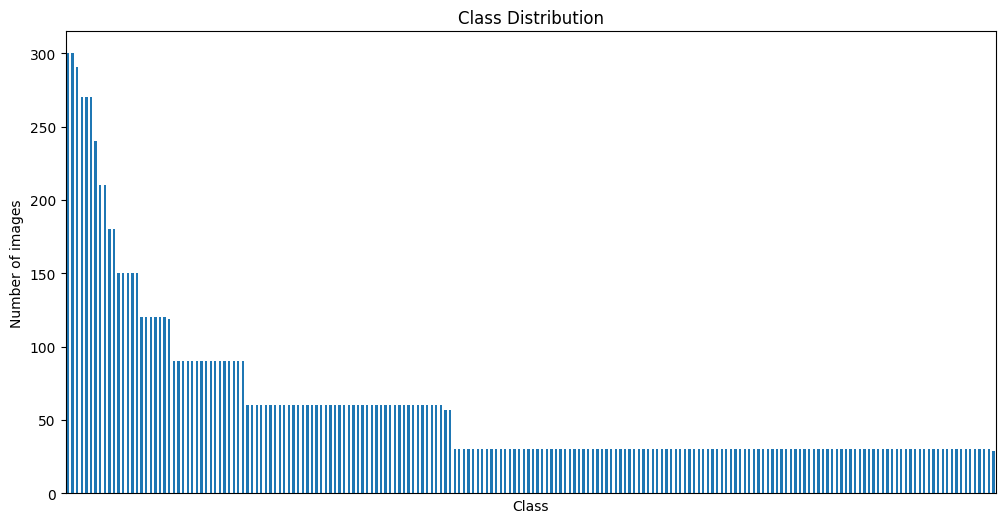

In [ ]:
print(class_counts)

plt.figure(figsize=(12,6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.xticks([])
plt.show()

### <b style="background-color:#e35b89; padding:5px; border-radius:5px; display: inline-block;">Loading Data</b>


In [ ]:
!unzip "/content/drive/MyDrive/dataset_split.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset_split/train/chordata_percidae/2702993_211786_eol-full-size-copy.jpg  
  inflating: /content/dataset_split/train/chordata_percidae/2702994_211786_eol-full-size-copy.jpg  
  inflating: /content/dataset_split/train/chordata_percidae/2702995_211786_eol-full-size-copy.jpg  
  inflating: /content/dataset_split/train/chordata_percidae/2702998_211786_eol-full-size-copy.jpg  
  inflating: /content/dataset_split/train/chordata_percidae/2703001_211786_eol-full-size-copy.jpg  
  inflating: /content/dataset_split/train/chordata_percidae/28479013_211786_eol-full-size-copy.jpg  
  inflating: /content/dataset_split/train/chordata_percidae/29882896_211786_eol-full-size-copy.jpg  
   creating: /content/dataset_split/train/chordata_phasianidae/
  inflating: /content/dataset_split/train/chordata_phasianidae/15267496_45516020_eol-full-size-copy.jpg  
  inflating: /content/dataset_split/train/chordata_phasianidae/15267497_45516

In [ ]:
base_path = "/content/dataset_split"

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_path}/train",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42
)

val = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_path}/val",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=42
)

test = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_path}/test",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=42
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Found 1798 files belonging to 202 classes.


### <b style="background-color:#e35b89; padding:5px; border-radius:5px; display: inline-block;">Visualizing Images</b>


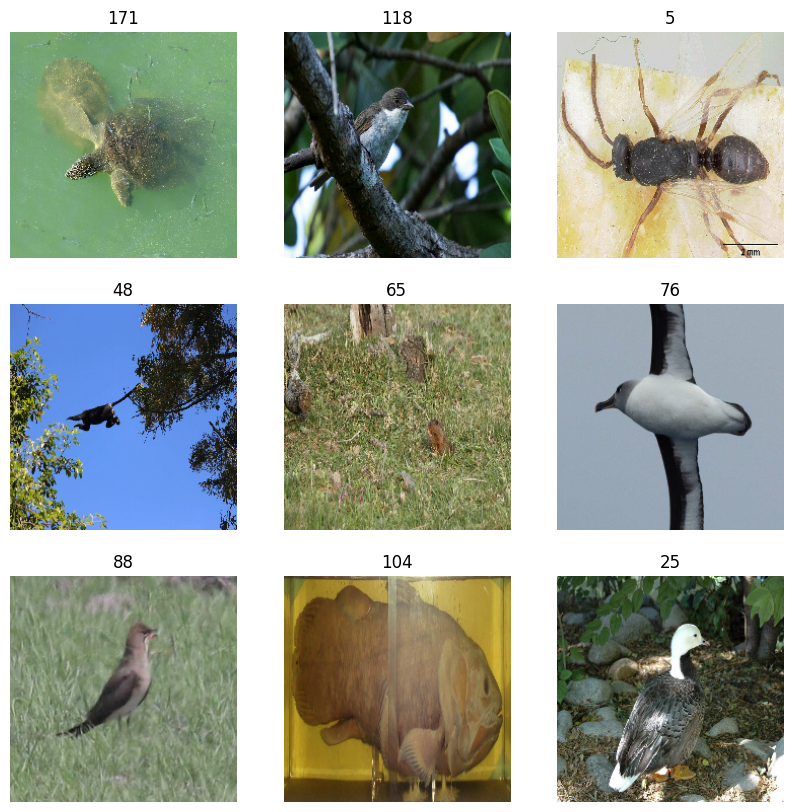

In [ ]:
vis_images(train)

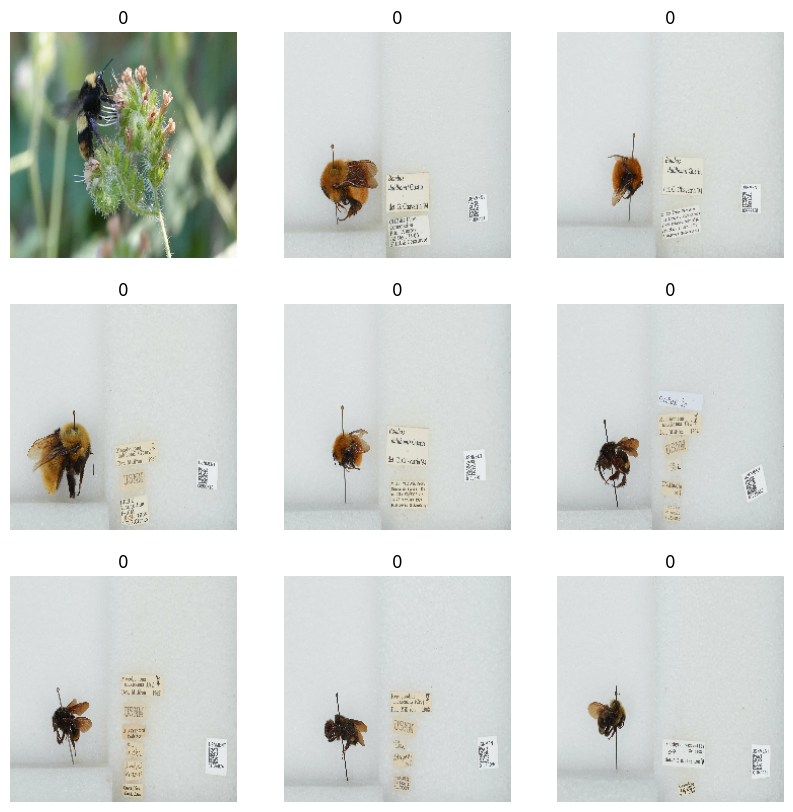

In [ ]:
vis_images(val)

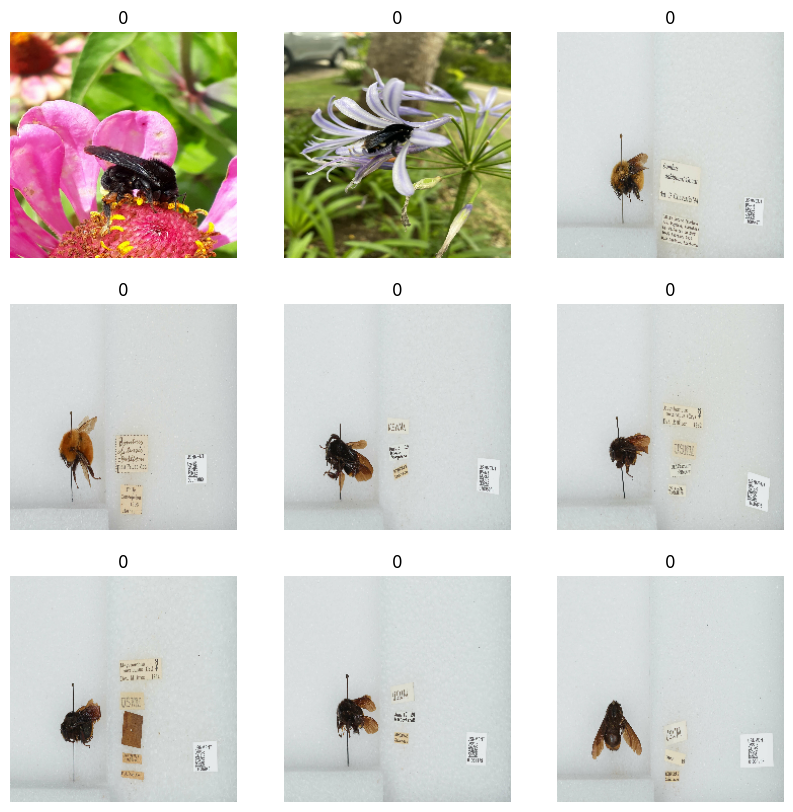

In [ ]:
vis_images(test)

<hr>

### <b style="background-color:#e35b89; padding:5px; border-radius:5px; display: inline-block;">Applying Resizing | Normalization</b>


In our initial approach, we normalized all images by scaling pixel values to the [0, 1] range, assuming a general practice for image preprocessing in deep learning models.

However, we later discovered that each Keras application model (e.g., DenseNet, InceptionResNetV2, EfficientNet) expects a specific preprocessing strategy that matches how it was originally trained on ImageNet.

Keras provides a dedicated preprocess_input function for each model under keras. It’s important to use the correct one to ensure compatibility and optimal performance. These functions may scale images to different ranges (e.g., [-1, 1] for Inception-based models) or apply ImageNet-specific normalization (e.g., mean subtraction for DenseNet).

To reflect this, we updated our pipeline to use the model-specific preprocessing functions from keras.applications, dynamically applied depending on the architecture in use.

<hr>

### <b style="background-color:#e35b89; padding:5px; border-radius:5px; display: inline-block;">Initial Tests - Simple and Complex Models (Manually Built)</b>


#### General Callbacks

In [ ]:
generic_callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath="Projeto.weights.h5",monitor="val_accuracy",save_best_only=True,save_weights_only=True,verbose=1)
]

#### Simple Model:

In [ ]:
model = Sequential([
    Conv2D(filters=3*8, kernel_size=(3,3), activation="relu", padding="same", input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=3*16, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2,2), strides=1),
    Conv2D(filters=3*32, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2,2), strides=1),
    Flatten(),
    Dense(units=202, activation="softmax")
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history_simple_model = model.fit(train, validation_data=val, epochs=5, verbose=2, callbacks=generic_callbacks)
### 5 EPOCHS, JUST TO TEST OUR HYPTOHESIS.

Epoch 1/5
263/263 - 174s - 663ms/step - accuracy: 0.0365 - loss: 89.5416 - val_accuracy: 0.0612 - val_loss: 4.9908 - learning_rate: 1.0000e-03
Epoch 2/5
263/263 - 157s - 597ms/step - accuracy: 0.0962 - loss: 4.7006 - val_accuracy: 0.0612 - val_loss: 5.1239 - learning_rate: 1.0000e-03
Epoch 3/5
263/263 - 157s - 598ms/step - accuracy: 0.1803 - loss: 4.1375 - val_accuracy: 0.0607 - val_loss: 5.6828 - learning_rate: 1.0000e-03
Epoch 4/5
263/263 - 170s - 646ms/step - accuracy: 0.2797 - loss: 3.5661 - val_accuracy: 0.0629 - val_loss: 7.4961 - learning_rate: 1.0000e-03
Epoch 5/5
263/263 - 167s - 634ms/step - accuracy: 0.3786 - loss: 3.0408 - val_accuracy: 0.0612 - val_loss: 9.1018 - learning_rate: 5.0000e-04


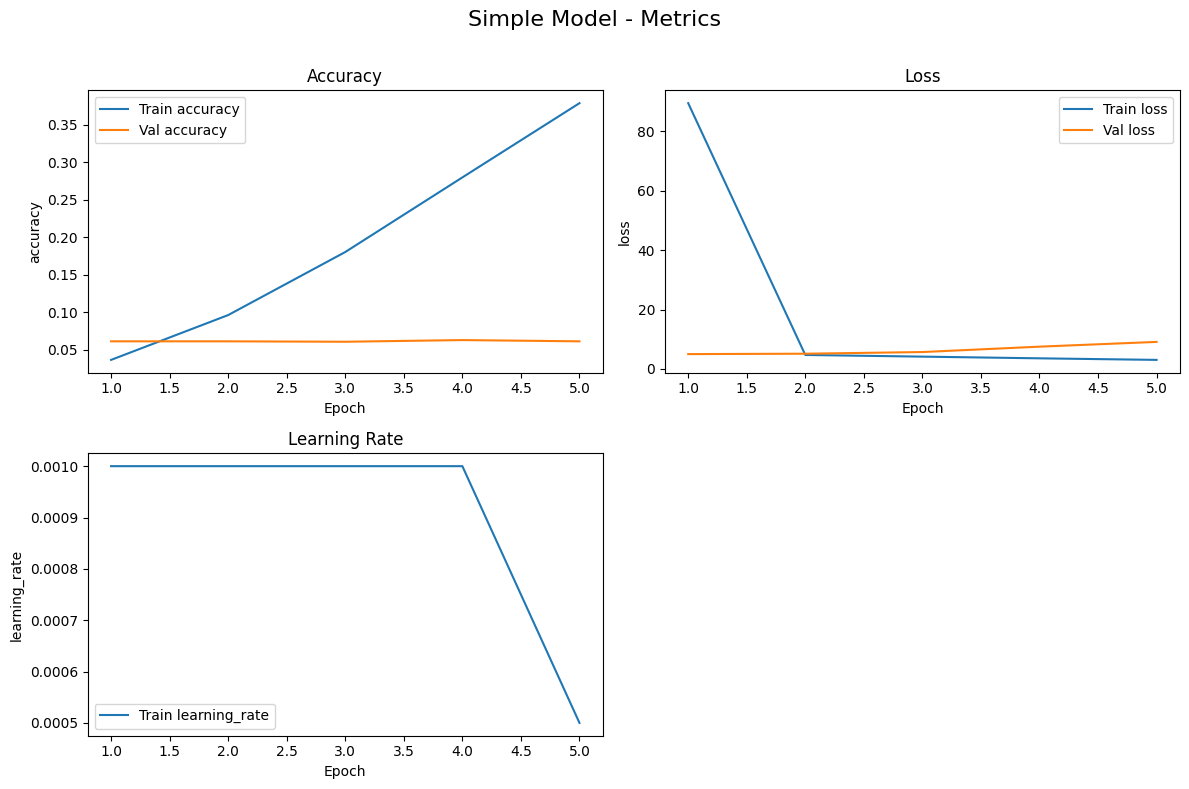

In [ ]:
plot_all_metrics(history_simple_model, title = "Simple Model - Metrics")

- *Way too simple, severe overfitting, not the best approach...*

#### Complex Model:

In [ ]:
## Defining the main class which will be called and will contain our model's parameters.
## It inherits from keras.Model class

## Why

class CNN1(Model):

    def __init__(self, activation = "relu"):
        # Calling super().__init__ method refers to the parent class Model.
        # Why is this important? - register the model, it properly initializes the Keras Model class
        # allowing TF to manage layers, forward propagation, and model metadata correctly.

        # Allows Model Methods to Work --> Methods like .fit(), .predict(), and .save(), depend
        # on Model being initialized properly.
        super().__init__()


       #### BLOCK 1
        self.conv1_l = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv1_l")
        self.batch1 = BatchNormalization()
        self.conv1_r = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv1_r")
        self.batch2 = BatchNormalization()
        self.maxpool1 = MaxPooling2D(pool_size=(2,2), padding="same", name="maxpool1")

        #### BLOCK 2
        self.conv2_l = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv2_l")
        self.batch3 = BatchNormalization()
        self.conv2_r = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv2_r")
        self.batch4 = BatchNormalization()
        self.maxpool2 = MaxPooling2D(pool_size=(2,2), padding="same", name="maxpool2")

        #### FLATTEN AND DENSE
        self.flatten_layer = Flatten()
        self.dropout_layer = Dropout(rate=0.5)
        self.batch5 = BatchNormalization()
        self.dense_layer = Dense(units=202, activation="softmax", name="classification")

    def call(self, inputs):
        x = inputs

        # BLOCK 1
        x_l = self.conv1_l(x)
        x_l = self.batch1(x_l)
        x_r = self.conv1_r(x)
        x_r = self.batch2(x_r)
        x = add([x_l,x_r])
        x = self.maxpool1(x)

        # BLOCK 2
        x_l2 = self.conv2_l(x)
        x_l2 = self.batch3(x_l2)
        x_r2 = self.conv2_r(x)
        x_r2 = self.batch4(x_r2)
        x = add([x_l2,x_r2])
        x = self.maxpool2(x)

        x = self.flatten_layer(x)
        x = self.dropout_layer(x)
        x = self.batch5(x)
        x = self.dense_layer(x)

        return x

#### Model Summary

In [ ]:
model = CNN1
model_summary(model,input_shape=(224,224,3))

Model: "cnn1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_l (Conv2D)                │ (None, 222, 222, 192)  │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_406         │ (None, 222, 222, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_r (Conv2D)                │ (None, 222, 222, 192)  │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_407         │ (None, 222, 222, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 111, 111, 192)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_l (Conv2D)                │ (None, 109, 109, 192)  │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_408         │ (None, 109, 109, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_r (Conv2D)                │ (None, 109, 109, 192)  │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_409         │ (None, 109, 109, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling2D)         │ (None, 55, 55, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 580800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 580800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_410         │ (None, 580800)         │     2,323,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 202)            │   117,321,802 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,322,762 (458.99 MB)

 Trainable params: 119,159,626 (454.56 MB)

 Non-trainable params: 1,163,136 (4.44 MB)

<CNN1 name=cnn1, built=False>

Notes:<br>
- Infeasible to run this model, taking more than 10+ hours to run 4 epochs.<br>
- It is clear that while trying both sides of the spectrum, neither a simple model, which trains fast will achieve decent results, nor a very complex one which might have the possibility to achieve the kind of accuracy we aim for, but it is just far too much time to spend, making us unable to run several experiments.<br>
- For these reasos, we conclude that we should probably aim for a Transfer Learning approach, using model's pre-trained weights, and tweaking some architecture details as well as experimenting with Data Augmentation might be the best approach forward.

<hr>

### <b style="background-color:#e35b89; padding:5px; border-radius:5px; display: inline-block;">Transfer Learning</b>


#### 1. InceptionResNetV2

In [ ]:
train_inception = train
validation_inception = val
test_inception = test

##### Augmentation Pipeline - For First Few Runs

In [ ]:
data_augmentation_inception = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.35),
    RandomZoom(0.15),
    RandomContrast(0.2, value_range=(-1,1)),
    RandomSharpness(0.3, value_range=(-1,1))
    ])


##### Augmentation Pipeline - Visualization

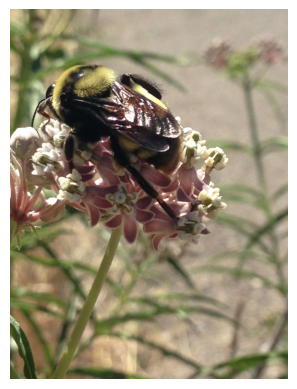

In [ ]:
image_file_path = Path("/content/drive/MyDrive/dl_run/imageexample.jpg")
normal_img_ex = imread(image_file_path)
show_image(normal_img_ex)

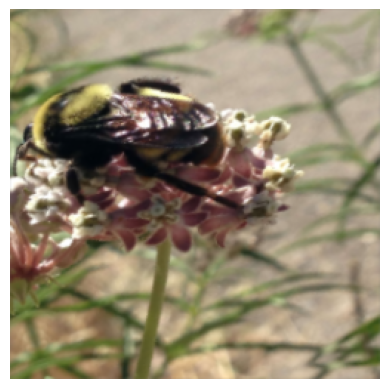

In [ ]:
# Adapted to InceptionResNetV2 Preprocessing
normalized_img = tf.image.resize(normal_img_ex, (250, 250)) / 127.5 - 1.0
augmented_ex = data_augmentation_inception(tf.expand_dims(normalized_img, 0))[0].numpy()

# Rescaled for display
augmented_ex_vis = (augmented_ex + 1.0) / 2.0
show_image(augmented_ex_vis)


##### Autotune

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_inception = train_inception.prefetch(AUTOTUNE)
validation_inception = validation_inception.prefetch(AUTOTUNE)
test_inception = test_inception.prefetch(AUTOTUNE)

##### Aplying Normalization / Preprocess_input

In [ ]:
train_inception = train_inception.map(lambda x, y: (preprocess_inception(x), y))
validation_inception = validation_inception.map(lambda x, y: (preprocess_inception(x), y))
test_inception = test_inception.map(lambda x, y: (preprocess_inception(x), y))

In [ ]:
check_sizes(train_inception)
print("--------------------------")
check_sizes(validation_inception)
print("--------------------------")
check_sizes(test_inception)

Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: -1.0
Max Pixel Value: 1.0
Label Batch Shape: (32, 202)
--------------------------
Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: -1.0
Max Pixel Value: 1.0
Label Batch Shape: (32, 202)
--------------------------
Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: -1.0
Max Pixel Value: 1.0
Label Batch Shape: (32, 202)


<hr>

##### Sampled Data Test Run

- More efficient time wise and key to get a gauge on performance. To check if it's worth testing or not.

In [ ]:
sample_train = (
    train_inception.unbatch().take(1500).repeat().batch(8)
)

sample_val = (
    validation_inception.unbatch().take(500).repeat().batch(8)
)

In [ ]:
class InRes_No_Aug_No_Reg(Model):
    def __init__(self):
        super().__init__()
        self.n_classes = 202
        self.pretrained_model = InceptionResNetV2(include_top=False)
        self.pretrained_model.trainable = False

        self.flatten = Flatten()
        self.dropout = Dropout(0.2)
        self.dense = Dense(self.n_classes, activation="softmax")

    def call(self, inputs, training=False):
        x = inputs
        x = self.pretrained_model(x)
        x = self.flatten(x)
        x = self.dropout(x, training=training)
        return self.dense(x)

In [ ]:
model1 = InRes_No_Aug_No_Reg()
model_summary(InRes_No_Aug_No_Reg)

Model: "in_res__no__aug__no__reg_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 202)            │     7,757,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,093,738 (236.87 MB)

 Trainable params: 7,757,002 (29.59 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

<InRes_No_Aug_No_Reg name=in_res__no__aug__no__reg_3, built=False>

In [ ]:
model1.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=3e-4),
               loss="categorical_crossentropy",
               metrics=['accuracy',
                        TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
                        F1Score(average='macro', name='f1_macro'),
                        F1Score(average='weighted', name='f1_weighted')]
               )

test1_inres_no_aug = model1.fit(
    sample_train,
    validation_data=sample_val,
    epochs=10,
    steps_per_epoch = 1500 // 8,
    validation_steps = 500 // 8,
    callbacks=generic_callbacks,
    verbose=2
)

Epoch 1/10
187/187 - 89s - 475ms/step - accuracy: 0.2132 - f1_macro: 0.1380 - f1_weighted: 0.2152 - loss: 31.3723 - top_5_accuracy: 0.3663 - val_accuracy: 0.3690 - val_f1_macro: 0.0717 - val_f1_weighted: 0.4178 - val_loss: 31.1501 - val_top_5_accuracy: 0.5302 - learning_rate: 1.0000e-03
Epoch 2/10
187/187 - 40s - 214ms/step - accuracy: 0.6798 - f1_macro: 0.6587 - f1_weighted: 0.6796 - loss: 8.8357 - top_5_accuracy: 0.8743 - val_accuracy: 0.4073 - val_f1_macro: 0.0778 - val_f1_weighted: 0.4545 - val_loss: 32.4526 - val_top_5_accuracy: 0.5806 - learning_rate: 1.0000e-03
Epoch 3/10
187/187 - 38s - 203ms/step - accuracy: 0.7493 - f1_macro: 0.7380 - f1_weighted: 0.7503 - loss: 6.2347 - top_5_accuracy: 0.9298 - val_accuracy: 0.4758 - val_f1_macro: 0.0954 - val_f1_weighted: 0.5296 - val_loss: 29.7613 - val_top_5_accuracy: 0.6391 - learning_rate: 1.0000e-03
Epoch 4/10
187/187 - 35s - 188ms/step - accuracy: 0.8402 - f1_macro: 0.8230 - f1_weighted: 0.8404 - loss: 4.3965 - top_5_accuracy: 0.9619 

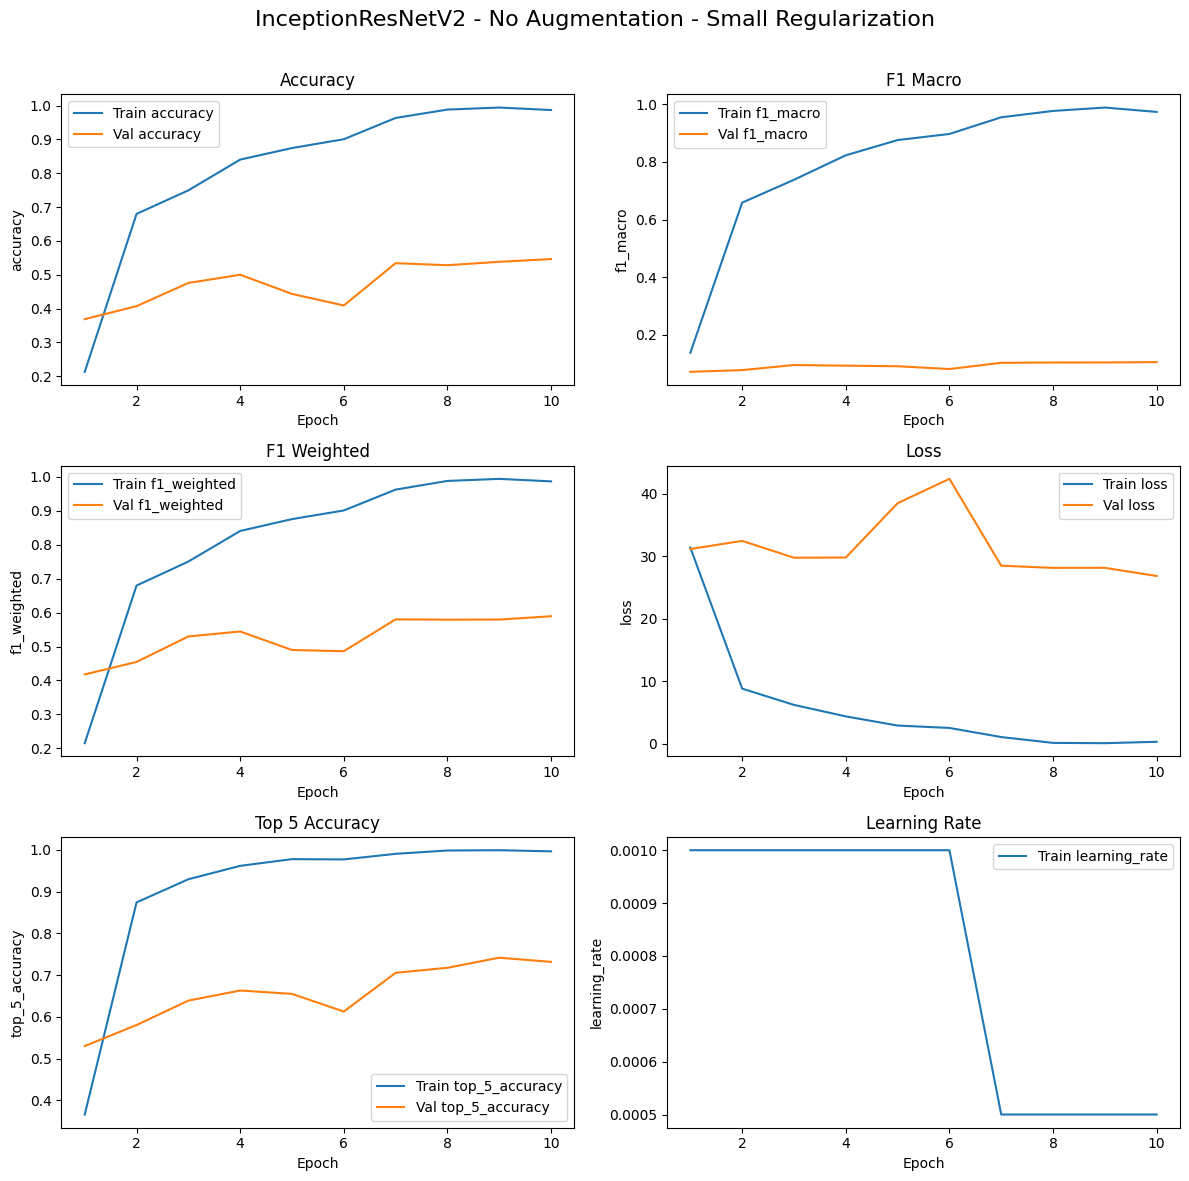

In [ ]:
plot_all_metrics(test1_inres_no_aug, "InceptionResNetV2 - No Augmentation - Small Regularization")

##### Observations:
- Learning far too quick -> Solution: Reduce LR.
- Generalizability: Model has trouble generalizing well to the validation set. In the sense that, it overfits quickly to the training set (also due to LR).
    - Solution: Data Augmentation will certainly help. Not only in terms of generalization but most likely also in terms of performance.
- Dropout & L2/L1 Regularization: Could help with problem mentioned previously.

<hr>


##### Evaluate on Test Set

In [ ]:
y_true_test_model1 = []
y_pred_probs_test_model1 = []

for x_batch, y_batch in test_inception:
    preds = model1.predict(x_batch, verbose=0)
    y_pred_probs_test_model1.append(preds)
    y_true_test_model1.append(y_batch.numpy())

y_true_test_model1 = np.concatenate(y_true_test_model1, axis=0)
y_pred_probs_test_model1 = np.concatenate(y_pred_probs_test_model1, axis=0)

In [ ]:
acc_test = compute_accuracy(y_true_test_model1, y_pred_probs_test_model1)
f1_macro_test = compute_f1_macro(y_true_test_model1, y_pred_probs_test_model1)
f1_weighted_test = compute_f1_weighted(y_true_test_model1, y_pred_probs_test_model1)
top5_acc_test = compute_top5_accuracy(y_true_test_model1, y_pred_probs_test_model1)

print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test F1 Macro: {f1_macro_test:.4f}")
print(f"Test F1 Weighted: {f1_weighted_test:.4f}")
print(f"Test Top-5 Accuracy: {top5_acc_test:.4f}")

Test Accuracy: 0.4127
Test F1 Macro: 0.3025
Test F1 Weighted: 0.3904
Test Top-5 Accuracy: 0.6429


<hr>

Callbacks

In [ ]:
callbacks_baseline = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ModelCheckpoint("best_inres_baseline_aug.keras", save_best_only=True, monitor="val_loss")
]

callbacks_finetune = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7),
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
    ModelCheckpoint("best_inres_finetuned_aug.keras", save_best_only=True, monitor="val_loss")
]

<hr>

Build the model: Baseline - A General Purpose Model

- Building a General Purpose Model to Allow for Reusability and Customization: - Available in the Library

In [ ]:
model_with_aug = InResCustom(
    use_augmentation=True,
    dropout_rate=0.4,
    regularizer=None,
    train_base=False
)

model_summary(InResCustom)
model_with_aug.compile(
    optimizer=AdamW(learning_rate=0.00001,weight_decay=3e-4),
    loss="categorical_crossentropy",
    metrics=['accuracy',
            TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
            F1Score(average='macro', name='f1_macro'),
            F1Score(average='weighted', name='f1_weighted')]
)

Model: "in_res_custom_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 202)            │     7,757,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,093,738 (236.87 MB)

 Trainable params: 7,757,002 (29.59 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [ ]:
test2_inres_minor_aug = model_with_aug.fit(
    sample_train,
    validation_data=sample_val,
    epochs=30,
    steps_per_epoch = 1500 // 8,
    validation_steps = 500 // 8,
    callbacks=callbacks_baseline,
    verbose=2
)

Epoch 1/30
187/187 - 76s - 407ms/step - accuracy: 0.0247 - f1_macro: 0.0094 - f1_weighted: 0.0215 - loss: 6.8021 - top_5_accuracy: 0.0735 - val_accuracy: 0.1855 - val_f1_macro: 0.0145 - val_f1_weighted: 0.1770 - val_loss: 4.8732 - val_top_5_accuracy: 0.3367 - learning_rate: 1.0000e-05
Epoch 2/30
187/187 - 37s - 200ms/step - accuracy: 0.0675 - f1_macro: 0.0273 - f1_weighted: 0.0562 - loss: 5.6400 - top_5_accuracy: 0.1852 - val_accuracy: 0.2399 - val_f1_macro: 0.0208 - val_f1_weighted: 0.2259 - val_loss: 4.2457 - val_top_5_accuracy: 0.4093 - learning_rate: 1.0000e-05
Epoch 3/30
187/187 - 78s - 418ms/step - accuracy: 0.1130 - f1_macro: 0.0585 - f1_weighted: 0.0997 - loss: 4.8812 - top_5_accuracy: 0.2747 - val_accuracy: 0.3226 - val_f1_macro: 0.0356 - val_f1_weighted: 0.3093 - val_loss: 3.7057 - val_top_5_accuracy: 0.5101 - learning_rate: 1.0000e-05
Epoch 4/30
187/187 - 41s - 218ms/step - accuracy: 0.1671 - f1_macro: 0.0993 - f1_weighted: 0.1515 - loss: 4.2151 - top_5_accuracy: 0.3857 - va

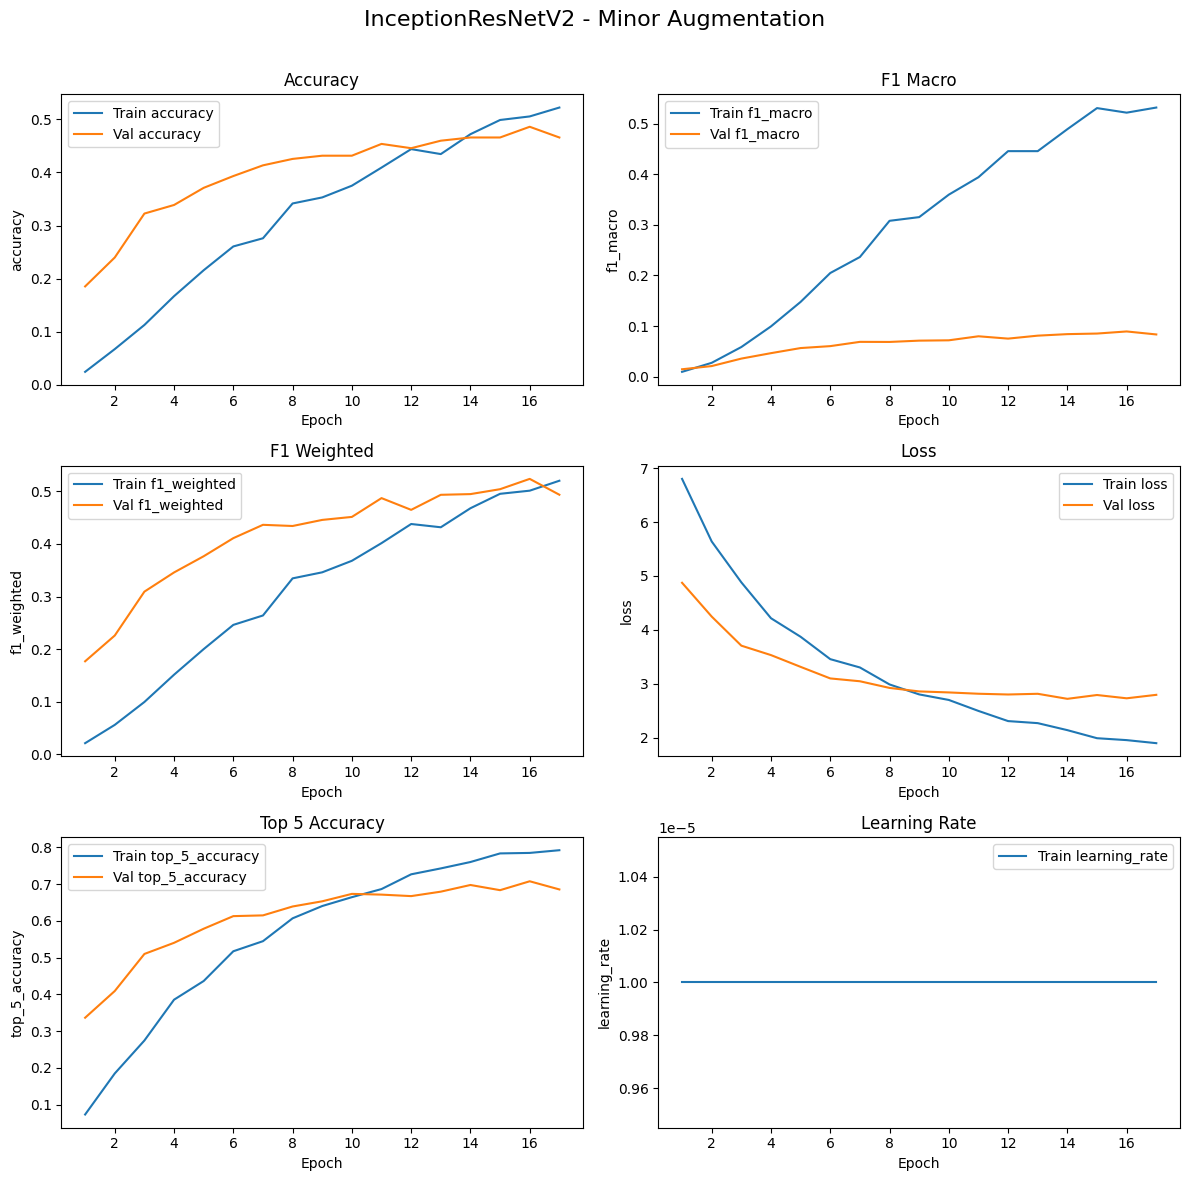

In [ ]:
plot_all_metrics(test2_inres_minor_aug, "InceptionResNetV2 - Minor Augmentation")

##### Observations:
- Reduce LR & D.A helped considerably in performance and generalization. Yet, the model underfits the data and can't quite generalize as well as we wish.
- A Key Point to this may be due to the fact that we are training on a sampled dataset with limited data. Next steps should include full dataset and a robust approach to D.A if early signs show bad generalization.

<hr>

##### Evaluate on Test Set

In [ ]:
y_true_test_model_with_aug = []
y_pred_probs_test_model_with_aug = []

for x_batch, y_batch in test_inception:
    preds = model_with_aug.predict(x_batch, verbose=0)
    y_pred_probs_test_model_with_aug.append(preds)
    y_true_test_model_with_aug.append(y_batch.numpy())

y_true_test_model_with_aug = np.concatenate(y_true_test_model_with_aug, axis=0)
y_pred_probs_test_model_with_aug = np.concatenate(y_pred_probs_test_model_with_aug, axis=0)

In [ ]:
acc_test = compute_accuracy(y_true_test_model_with_aug, y_pred_probs_test_model_with_aug)
f1_macro_test = compute_f1_macro(y_true_test_model_with_aug, y_pred_probs_test_model_with_aug)
f1_weighted_test = compute_f1_weighted(y_true_test_model_with_aug, y_pred_probs_test_model_with_aug)
top5_acc_test = compute_top5_accuracy(y_true_test_model_with_aug, y_pred_probs_test_model_with_aug)

print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test F1 Macro: {f1_macro_test:.4f}")
print(f"Test F1 Weighted: {f1_weighted_test:.4f}")
print(f"Test Top-5 Accuracy: {top5_acc_test:.4f}")

Test Accuracy: 0.3348
Test F1 Macro: 0.2194
Test F1 Weighted: 0.2890
Test Top-5 Accuracy: 0.6123


<hr>

##### Full Dataset Test Run

Data Augmentation - Customized

In [ ]:
custom_aug = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomContrast(0.075, value_range=(-1, 1)),
    RandomBrightness(0.075, value_range=(-1,1))
])

In [ ]:
## FULL DATASET TEST RUN ##

model_with_aug = InResCustom(
    use_augmentation=True,
    dropout_rate=0.4,
    regularizer=None,
    train_base=False,
    custom_aug_layers=custom_aug
)

model_with_aug.compile(
    optimizer=AdamW(learning_rate=0.00001, weight_decay=3e-4),
    loss="categorical_crossentropy",
    metrics=['accuracy',
            TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
            F1Score(average='macro', name='f1_macro'),
            F1Score(average='weighted', name='f1_weighted')]
)

history_baseline = model_with_aug.fit(
    train_inception,
    validation_data=validation_inception,
    epochs=50,
    callbacks=callbacks_baseline,
    verbose=2
)

Epoch 1/50
263/263 - 500s - 2s/step - accuracy: 0.0813 - f1_macro: 0.0397 - f1_weighted: 0.0735 - loss: 5.6099 - top_5_accuracy: 0.1964 - val_accuracy: 0.2732 - val_f1_macro: 0.1550 - val_f1_weighted: 0.2277 - val_loss: 3.5226 - val_top_5_accuracy: 0.5125 - learning_rate: 1.0000e-05
Epoch 2/50
263/263 - 483s - 2s/step - accuracy: 0.2300 - f1_macro: 0.1608 - f1_weighted: 0.2157 - loss: 3.8820 - top_5_accuracy: 0.4573 - val_accuracy: 0.3829 - val_f1_macro: 0.2820 - val_f1_weighted: 0.3451 - val_loss: 2.7332 - val_top_5_accuracy: 0.6722 - learning_rate: 1.0000e-05
Epoch 3/50
263/263 - 477s - 2s/step - accuracy: 0.3149 - f1_macro: 0.2576 - f1_weighted: 0.3018 - loss: 3.2084 - top_5_accuracy: 0.5820 - val_accuracy: 0.4335 - val_f1_macro: 0.3474 - val_f1_weighted: 0.4062 - val_loss: 2.3913 - val_top_5_accuracy: 0.7318 - learning_rate: 1.0000e-05
Epoch 4/50
263/263 - 497s - 2s/step - accuracy: 0.3548 - f1_macro: 0.3046 - f1_weighted: 0.3445 - loss: 2.8831 - top_5_accuracy: 0.6389 - val_accura

- Observations:
    - Previous Data Augmentation Pipeline:
        - Sequential([
        - RandomFlip("horizontal"),
        - RandomRotation(0.4),
        - RandomZoom(0.2),
        - RandomContrast(0.25, value_range=(-1, 1)),
        - RandomSharpness(0.15, value_range=(-1, 1)),
        - RandomSaturation(0.1, value_range=(-1, 1))])
            - Train_acc -> Around 0.5
            - Val_acc -> Around 0.55
    - New Pipeline:
        - Sequential([
        - RandomFlip("horizontal"),
        - RandomRotation(0.2),
        - RandomZoom(0.1),
        - RandomContrast(0.075, value_range=(-1, 1)),
        - RandomBrightness(0.075, value_range=(-1,1))])
            - Train_acc -> Around 0.74
            - Val_acc -> Around 0.62

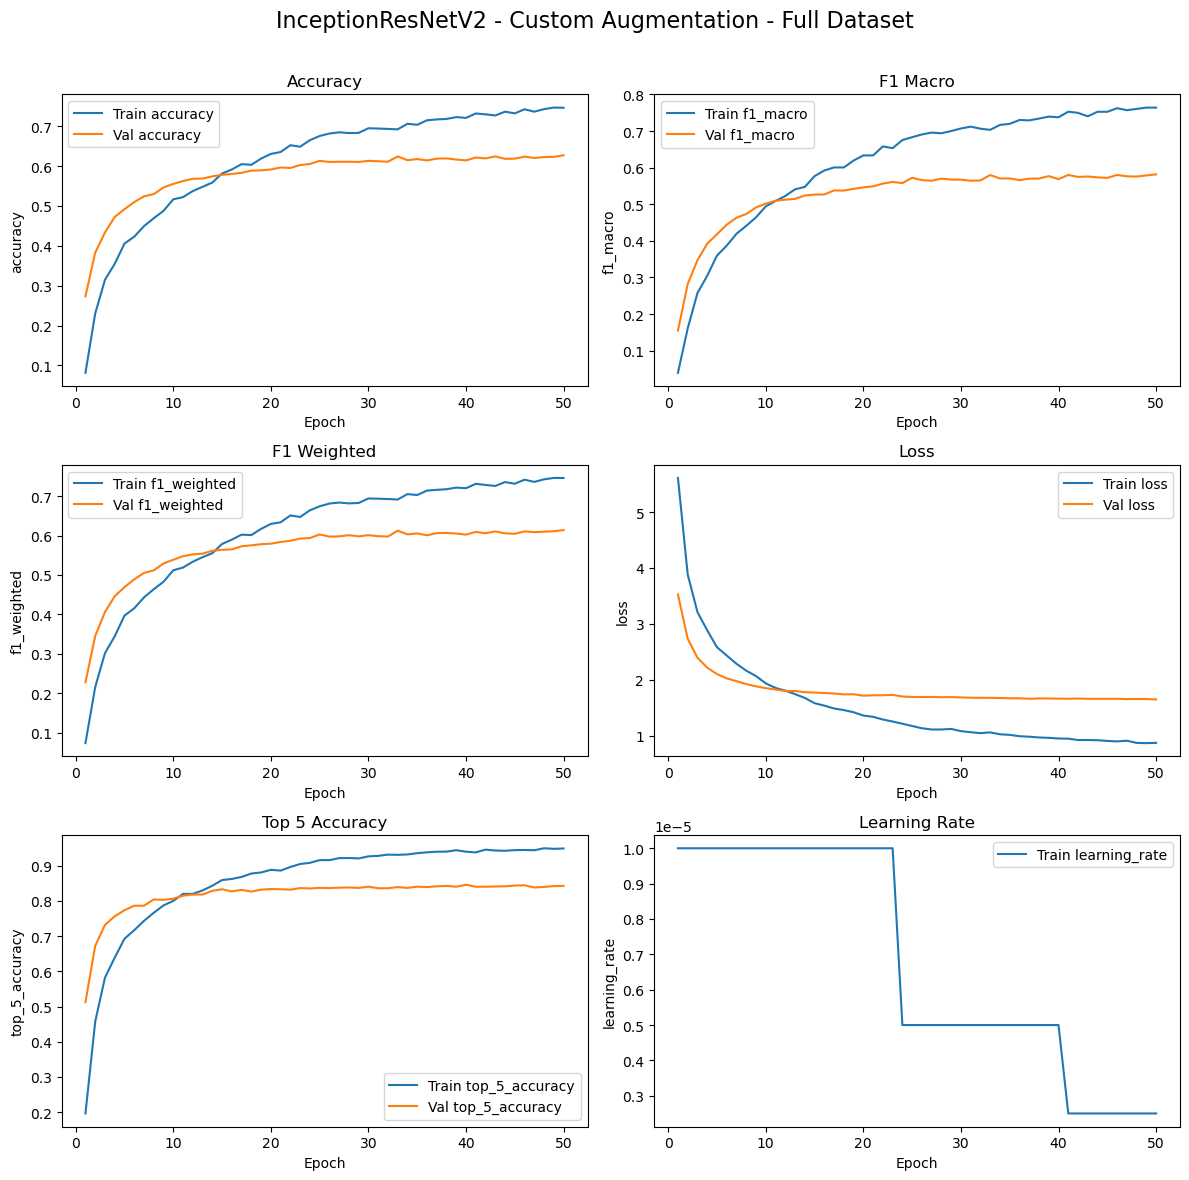

In [ ]:
plot_all_metrics(history_baseline, "InceptionResNetV2 - Custom Augmentation - Full Dataset")


 Evaluate on Test Set

In [ ]:
y_true_test_model_with_aug = []
y_pred_probs_test_model_with_aug = []

for x_batch, y_batch in test_inception:
    preds = model_with_aug.predict(x_batch, verbose=0)
    y_pred_probs_test_model_with_aug.append(preds)
    y_true_test_model_with_aug.append(y_batch.numpy())

y_true_test_model_with_aug = np.concatenate(y_true_test_model_with_aug, axis=0)
y_pred_probs_test_model_with_aug = np.concatenate(y_pred_probs_test_model_with_aug, axis=0)

2025-04-30 20:44:12.896957: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
acc_test = compute_accuracy(y_true_test_model_with_aug, y_pred_probs_test_model_with_aug)
f1_macro_test = compute_f1_macro(y_true_test_model_with_aug, y_pred_probs_test_model_with_aug)
f1_weighted_test = compute_f1_weighted(y_true_test_model_with_aug, y_pred_probs_test_model_with_aug)
top5_acc_test = compute_top5_accuracy(y_true_test_model_with_aug, y_pred_probs_test_model_with_aug)

print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test F1 Macro: {f1_macro_test:.4f}")
print(f"Test F1 Weighted: {f1_weighted_test:.4f}")
print(f"Test Top-5 Accuracy: {top5_acc_test:.4f}")

Test Accuracy: 0.6274
Test F1 Macro: 0.5859
Test F1 Weighted: 0.6168
Test Top-5 Accuracy: 0.8621


<hr>

##### Fine-Tuning

In [ ]:
## FINE-TUNING THE BASE MODEL ##
model_finetune_base = InResCustom(
    use_augmentation=True,
    dropout_rate=0.5,
    regularizer=None,
    train_base=False,
    custom_aug_layers=custom_aug
)

# ---- #
model_finetune_base(tf.keras.Input(shape=(224, 224, 3)))
model_finetune_base.load_weights("best_inres_baseline_aug.keras")
# ---- #

model_finetune, updated_callbacks = fine_tune(
    model_finetune_base,
    fine_tune_at=50,
    lr=1e-5,
    base_layer_name="inception_resnet_v2",
    checkpoint_path="best_inres_finetuned.keras",
    callbacks=callbacks_finetune
)
history_finetuned = model_finetune.fit(
    train_inception,
    validation_data=validation_inception,
    epochs=10,
    callbacks=callbacks_finetune,
    verbose=2
)

Epoch 1/10
263/263 - 574s - 2s/step - accuracy: 0.5995 - f1_macro: 0.5971 - f1_weighted: 0.5946 - loss: 1.6176 - top_5_accuracy: 0.8751 - val_accuracy: 0.5977 - val_f1_macro: 0.5487 - val_f1_weighted: 0.5799 - val_loss: 1.6133 - val_top_5_accuracy: 0.8403 - learning_rate: 1.0000e-05
Epoch 2/10
263/263 - 517s - 2s/step - accuracy: 0.6776 - f1_macro: 0.6846 - f1_weighted: 0.6743 - loss: 1.2080 - top_5_accuracy: 0.9251 - val_accuracy: 0.6093 - val_f1_macro: 0.5656 - val_f1_weighted: 0.5953 - val_loss: 1.5562 - val_top_5_accuracy: 0.8492 - learning_rate: 1.0000e-05
Epoch 3/10
263/263 - 533s - 2s/step - accuracy: 0.6950 - f1_macro: 0.7008 - f1_weighted: 0.6925 - loss: 1.1158 - top_5_accuracy: 0.9320 - val_accuracy: 0.6155 - val_f1_macro: 0.5702 - val_f1_weighted: 0.6027 - val_loss: 1.5370 - val_top_5_accuracy: 0.8497 - learning_rate: 1.0000e-05
Epoch 4/10
263/263 - 519s - 2s/step - accuracy: 0.7071 - f1_macro: 0.7197 - f1_weighted: 0.7056 - loss: 1.0518 - top_5_accuracy: 0.9403 - val_accura

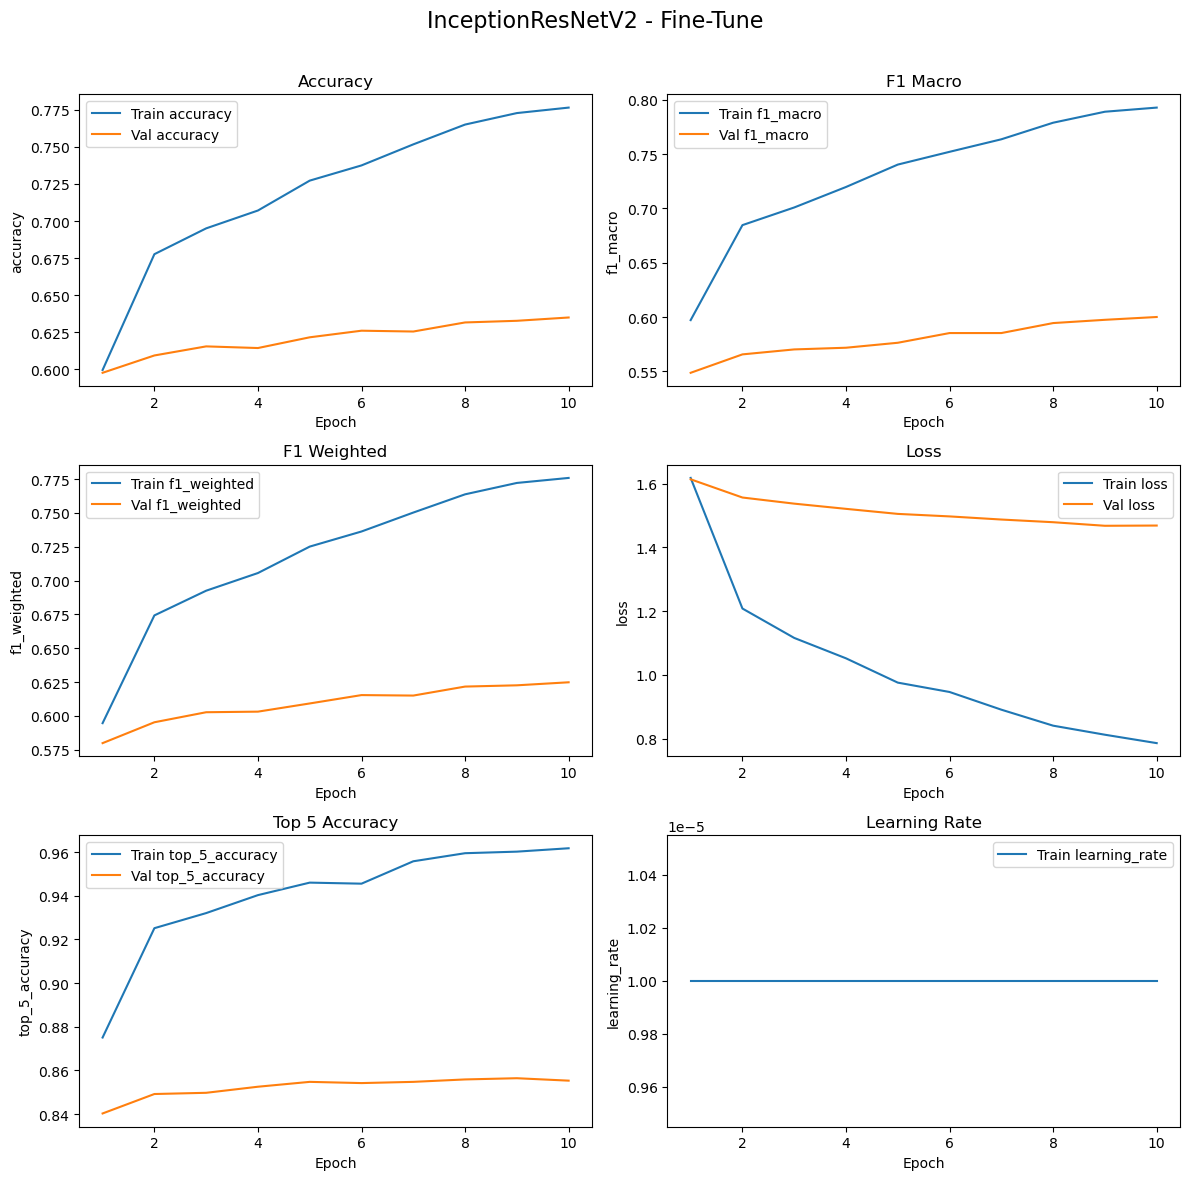

In [ ]:
plot_all_metrics(history_finetuned, "InceptionResNetV2 - Fine-Tune")

-> Clear Overfitting, no further improvements will be trialed at this moment, due to the success of the following models that will be presented.

- Nevertheless, steps that could be taken to mitigate this risk: Train on less layers; adapt earylstoppage callback; perhaps increase slightly dropout rate (altought it's quite agressive already)

-> A more "conservative" Approach to D.A pipeline clearly resulted in much better results.

##### Evaluate on Test Set

In [ ]:
y_true_test_model_finetune = []
y_pred_probs_test_model_finetune = []

for x_batch, y_batch in test_inception:
    preds = model_finetune.predict(x_batch, verbose=0)
    y_pred_probs_test_model_finetune.append(preds)
    y_true_test_model_finetune.append(y_batch.numpy())

y_true_test_model_finetune = np.concatenate(y_true_test_model_finetune, axis=0)
y_pred_probs_test_model_finetune = np.concatenate(y_pred_probs_test_model_finetune, axis=0)

2025-04-30 22:27:41.910501: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
acc_test = compute_accuracy(y_true_test_model_finetune, y_pred_probs_test_model_finetune)
f1_macro_test = compute_f1_macro(y_true_test_model_finetune, y_pred_probs_test_model_finetune)
f1_weighted_test = compute_f1_weighted(y_true_test_model_finetune, y_pred_probs_test_model_finetune)
top5_acc_test = compute_top5_accuracy(y_true_test_model_finetune, y_pred_probs_test_model_finetune)

print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test F1 Macro: {f1_macro_test:.4f}")
print(f"Test F1 Weighted: {f1_weighted_test:.4f}")
print(f"Test Top-5 Accuracy: {top5_acc_test:.4f}")

Test Accuracy: 0.6440
Test F1 Macro: 0.5972
Test F1 Weighted: 0.6351
Test Top-5 Accuracy: 0.8732


<hr>

##### D.A Visualization - Old Pipeline

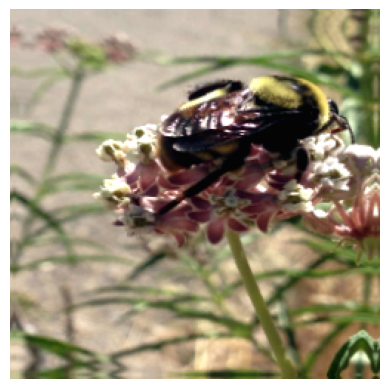

In [ ]:
old_pipeline = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.4),
    RandomZoom(0.2),
    RandomContrast(0.25, value_range=(-1, 1)),
    RandomBrightness(0.15, value_range=(-1,1))
])

# ADAPTED TO INCEPTIONRESNET PREPROCESSING
normalized_img = tf.image.resize(normal_img_ex, (250, 250)) / 127.5 - 1.0

# RESCALED FOR DISPLAY
augmented_ex = old_pipeline(tf.expand_dims(normalized_img, 0))[0].numpy()

augmented_ex_vis = (augmented_ex + 1.0) / 2.0
show_image(augmented_ex_vis)

##### D.A Visualization - New Pipeline

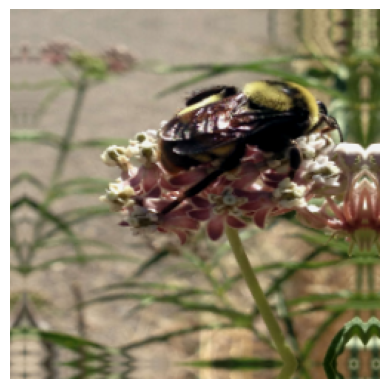

In [ ]:
# ADAPTED TO INCEPTIONRESNET PREPROCESSING
normalized_img = tf.image.resize(normal_img_ex, (250, 250)) / 127.5 - 1.0

# RESCALED FOR DISPLAY
augmented_ex = custom_aug(tf.expand_dims(normalized_img, 0))[0].numpy()

augmented_ex_vis = (augmented_ex + 1.0) / 2.0
show_image(augmented_ex_vis)

<hr>

#### 2. DenseNet121

In [ ]:
train_densenet121 = train
validation_densenet121 = val
test_densenet121 = test

##### Augmentation Pipeline - Visualization

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

In [ ]:
def augment(x, y):
    return data_augmentation(x), y

train_densenet121 = train_densenet121.map(augment)

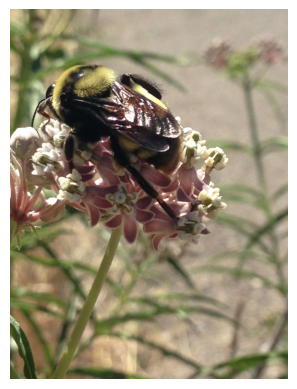

In [ ]:
image_file_path = Path("/content/drive/MyDrive/dl_run/imageexample.jpg")
normal_img_ex = imread(image_file_path)
show_image(normal_img_ex)

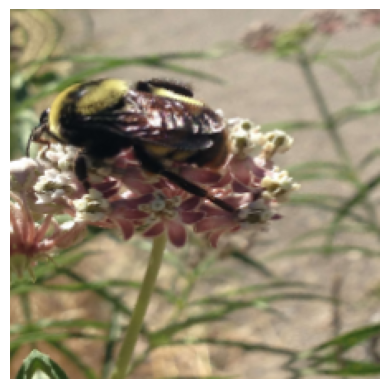

In [ ]:
#Resize
normalized_img = tf.image.resize(normal_img_ex, (224, 224)) / 255.0
augmented_ex = data_augmentation(tf.expand_dims(normalized_img, 0))[0].numpy()


show_image(augmented_ex)

##### Normalization

In [ ]:
check_sizes(train_densenet121)
print("--------------------------")
check_sizes(validation_densenet121)
print("--------------------------")
check_sizes(test_densenet121)

Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: 0.0
Max Pixel Value: 254.98969
Label Batch Shape: (32, 202)
--------------------------
Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Label Batch Shape: (32, 202)
--------------------------
Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: 0.0
Max Pixel Value: 255.0
Label Batch Shape: (32, 202)


In [ ]:
train_densenet121 = train_densenet121.map(lambda x,y: (preprocess_input_densenet(x), y))
validation_densenet121 = validation_densenet121.map(lambda x,y: (preprocess_input_densenet(x), y))
test_densenet121 = test_densenet121.map(lambda x,y: (preprocess_input_densenet(x), y))

In [ ]:
check_sizes(train_densenet121)
print("--------------------------")
check_sizes(validation_densenet121)
print("--------------------------")
check_sizes(test_densenet121)

Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: -2.117904
Max Pixel Value: 2.64
Label Batch Shape: (32, 202)
--------------------------
Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: -2.117904
Max Pixel Value: 2.64
Label Batch Shape: (32, 202)
--------------------------
Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: -2.117904
Max Pixel Value: 2.64
Label Batch Shape: (32, 202)


##### Autotune

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_densenet121 = train_densenet121.prefetch(AUTOTUNE)
validation_densenet121 = validation_densenet121.prefetch(AUTOTUNE)
test_densenet121 = test_densenet121.prefetch(AUTOTUNE)

##### Building the Models

Callbacks

In [ ]:
callbacks_densenet121 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint("best.keras", save_best_only=True)
]

##### Baseline Model

In [ ]:
NUM_CLASSES = train.element_spec[1].shape[-1]

In [ ]:
def create_densenet121_model(input_shape=(224, 224, 3), dropout_rate=0.5, num_classes=NUM_CLASSES):

    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        name="densenet121_base"
    )

    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=AdamW(learning_rate=0.0005, weight_decay=3e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
                F1Score(average='macro', name='f1_macro'),
                F1Score(average='weighted', name='f1_weighted')]
        )

    return model, base_model

In [ ]:
baseline_model, base_model_densenet = create_densenet121_model()

callbacks_densenet121[2] = ModelCheckpoint("best_densenet121_baseline.keras", save_best_only=True)

history_baseline_model = baseline_model.fit(
    train_densenet121,
    validation_data=validation_densenet121,
    epochs=60,
    callbacks=callbacks_densenet121
)

Epoch 1/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 269s 975ms/step - accuracy: 0.0502 - f1_macro: 0.0164 - f1_weighted: 0.0383 - loss: 5.5825 - top_5_accuracy: 0.1341 - val_accuracy: 0.2749 - val_f1_macro: 0.1170 - val_f1_weighted: 0.2050 - val_loss: 3.4426 - val_top_5_accuracy: 0.5225 - learning_rate: 5.0000e-04
Epoch 2/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 233s 884ms/step - accuracy: 0.2087 - f1_macro: 0.1055 - f1_weighted: 0.1764 - loss: 3.7667 - top_5_accuracy: 0.4274 - val_accuracy: 0.4090 - val_f1_macro: 0.2632 - val_f1_weighted: 0.3506 - val_loss: 2.6339 - val_top_5_accuracy: 0.6950 - learning_rate: 5.0000e-04
Epoch 3/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 233s 885ms/step - accuracy: 0.3207 - f1_macro: 0.2225 - f1_weighted: 0.2934 - loss: 2.9862 - top_5_accuracy: 0.5946 - val_accuracy: 0.4841 - val_f1_macro: 0.3693 - val_f1_weighted: 0.4404 - val_loss: 2.2233 - val_top_5_accuracy: 0.7652 - learning_rate: 5.0000e-04
Epoch 4/60
263/263 ━━━━━━━━━━━━━━━━━━━━ 231s 878ms/step - accuracy: 0.3859 - f1_macro: 0

##### Fine-Tuning

In [ ]:
finetuned_model, finetuned_callbacks = fine_tune(
    model=baseline_model,
    fine_tune_at=50,
    lr=1e-5,
    base_model=base_model_densenet,
    base_layer_name="densenet121_base",
    checkpoint_path="best_densenet_finetuned.keras",
    callbacks=callbacks_densenet121
)

history_finetuned_model = finetuned_model.fit(
    train_densenet121,
    validation_data=validation_densenet121,
    epochs=30,
    callbacks=finetuned_callbacks
)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.6287 - f1_macro: 0.6180 - f1_weighted: 0.6269 - loss: 1.3691 - top_5_accuracy: 0.8754 - val_accuracy: 0.6617 - val_f1_macro: 0.6271 - val_f1_weighted: 0.6482 - val_loss: 1.3859 - val_top_5_accuracy: 0.8687 - learning_rate: 1.0000e-05
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.6363 - f1_macro: 0.6209 - f1_weighted: 0.6343 - loss: 1.3351 - top_5_accuracy: 0.8791 - val_accuracy: 0.6656 - val_f1_macro: 0.6293 - val_f1_weighted: 0.6516 - val_loss: 1.3799 - val_top_5_accuracy: 0.8676 - learning_rate: 1.0000e-05
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.6412 - f1_macro: 0.6290 - f1_weighted: 0.6403 - loss: 1.2848 - top_5_accuracy: 0.8909 - val_accuracy: 0.6733 - val_f1_macro: 0.6400 - val_f1_weighted: 0.6606 - val_loss: 1.3667 - val_top_5_accuracy: 0.8720 - learning_rate: 1.0000e-05
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.6626 - f1_macro: 0.6475 - f1_w

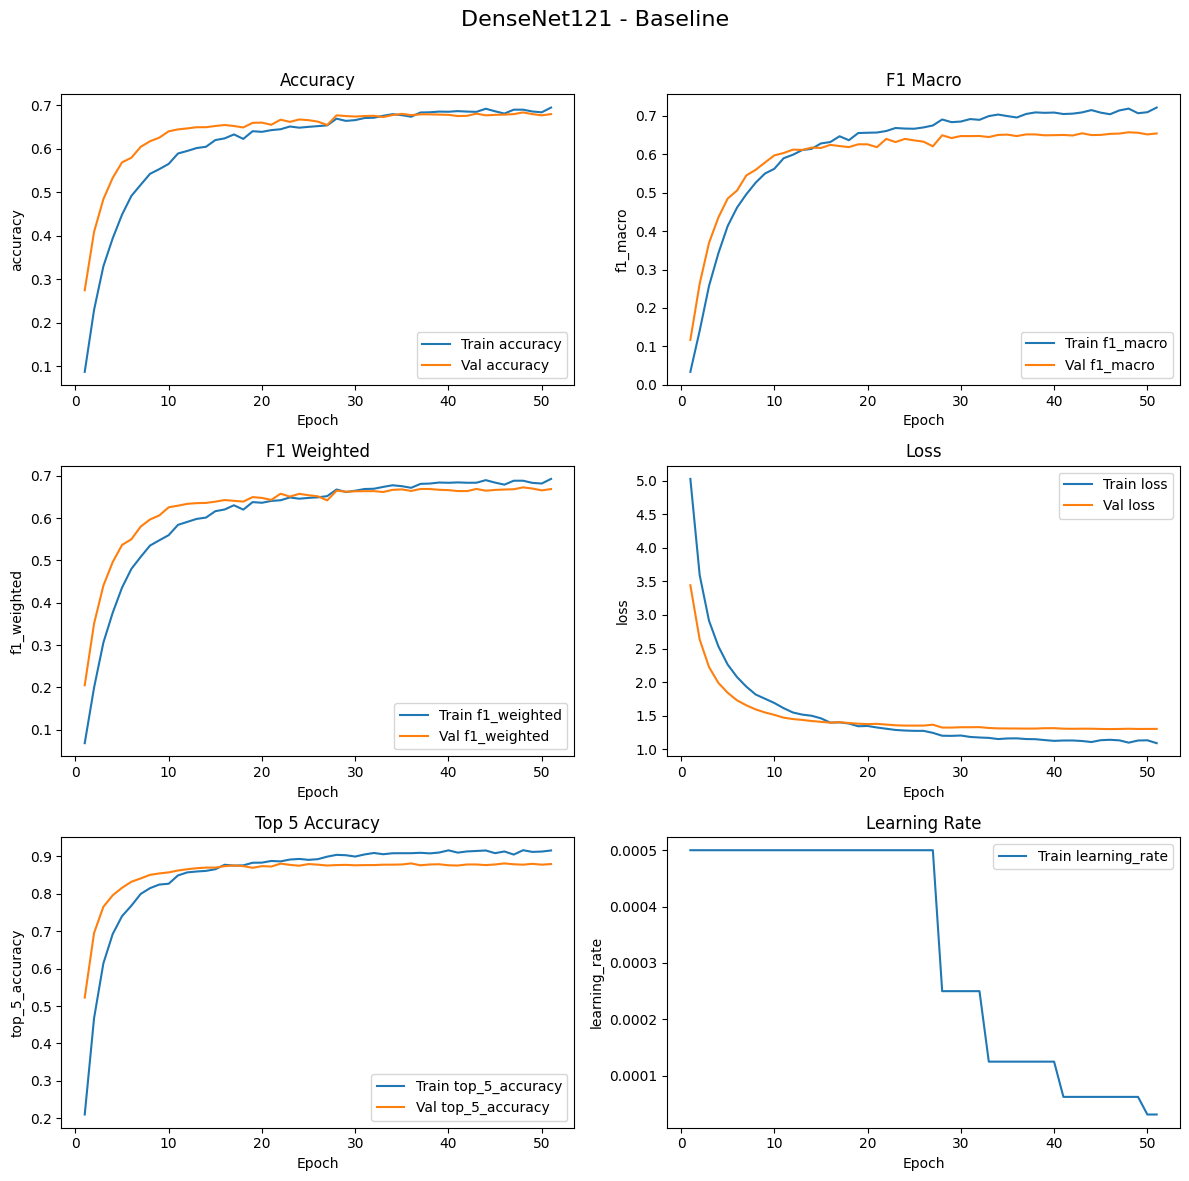

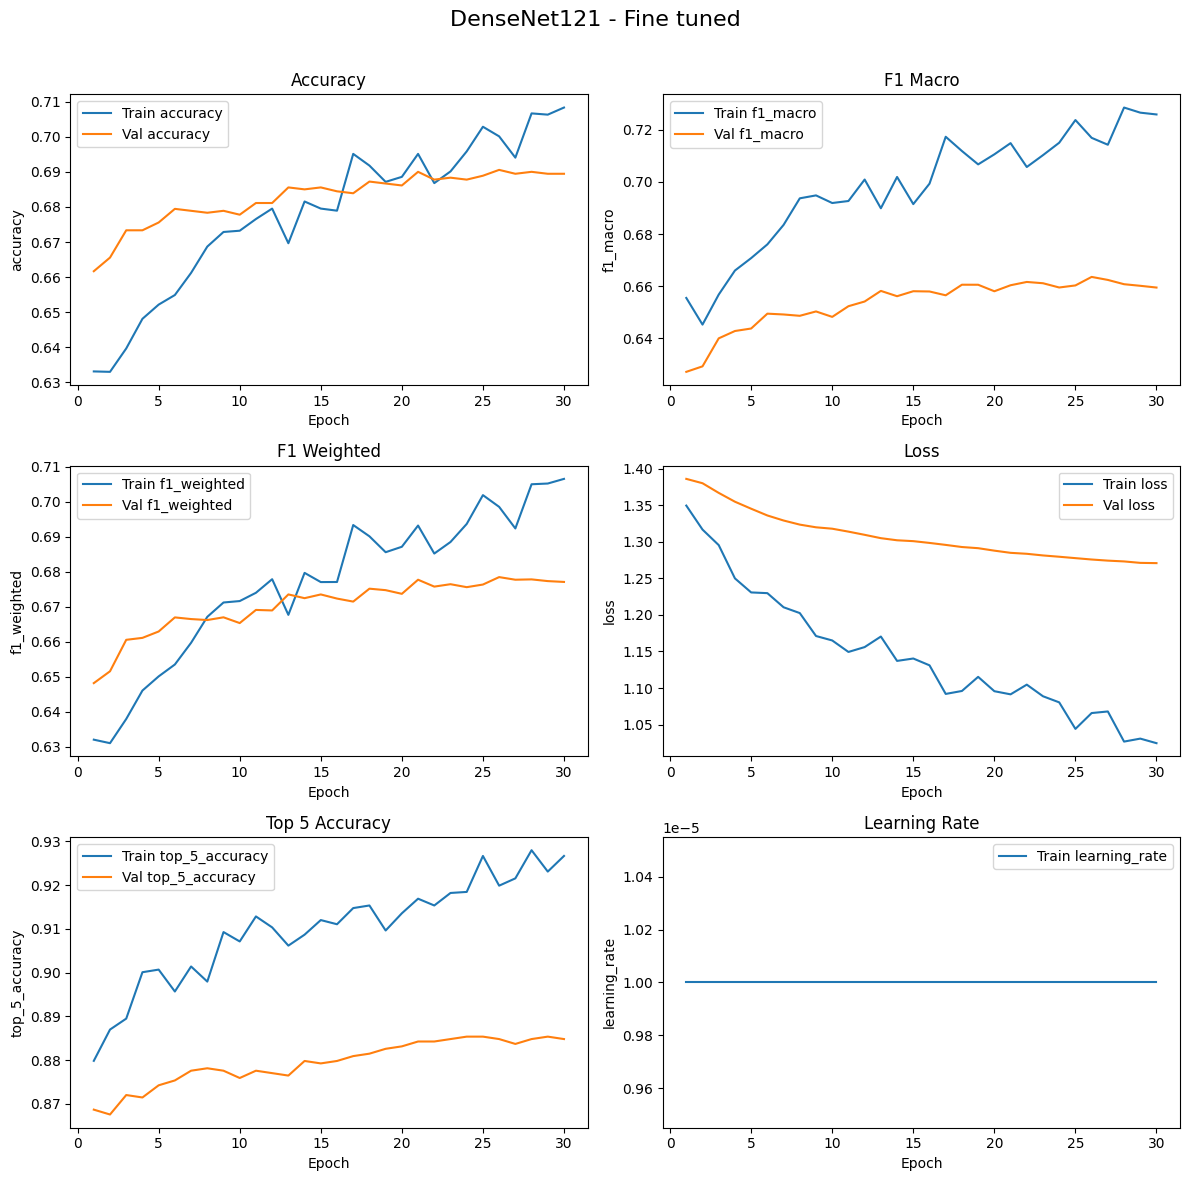

In [ ]:
plot_all_metrics(history_baseline_model, title="DenseNet121 - Baseline")
plot_all_metrics(history_finetuned_model, title="DenseNet121 - Fine tuned")

Evaluate on test

In [ ]:
y_true_test_baseline_model = []
y_pred_probs_test_baseline_model = []

for x_batch, y_batch in test_densenet121:
    preds = baseline_model.predict(x_batch, verbose=0)
    y_pred_probs_test_baseline_model.append(preds)
    y_true_test_baseline_model.append(y_batch.numpy())

y_true_test_baseline_model = np.concatenate(y_true_test_baseline_model, axis=0)
y_pred_probs_test_baseline_model = np.concatenate(y_pred_probs_test_baseline_model, axis=0)

In [ ]:
acc_test = compute_accuracy(y_true_test_baseline_model, y_pred_probs_test_baseline_model)
f1_macro_test = compute_f1_macro(y_true_test_baseline_model, y_pred_probs_test_baseline_model)
f1_weighted_test = compute_f1_weighted(y_true_test_baseline_model, y_pred_probs_test_baseline_model)
top5_acc_test = compute_top5_accuracy(y_true_test_baseline_model, y_pred_probs_test_baseline_model)

print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test F1 Macro: {f1_macro_test:.4f}")
print(f"Test F1 Weighted: {f1_weighted_test:.4f}")
print(f"Test Top-5 Accuracy: {top5_acc_test:.4f}")

Test Accuracy: 0.7052
Test F1 Macro: 0.6845
Test F1 Weighted: 0.6958
Test Top-5 Accuracy: 0.8921


#### 3. ConvNeXtBase

Note: Due to the computational cost of training this model, we executed it in a separate Google Colab notebook. In this notebook, we focus on presenting and analyzing the training results after importing the history and model from Colab.

The Colab notebook is accessible and named ConvNext_Colab.

In [ ]:
train_convnext = train.prefetch(tf.data.AUTOTUNE)
val_convnext = val.prefetch(tf.data.AUTOTUNE)
test_convnext = test.prefetch(tf.data.AUTOTUNE)

##### Importing History (from colab notebook)

In [ ]:
with open("/content/drive/MyDrive/dl_run/ConvNext/history_convnext_batch32_full.pkl", "rb") as f:
    history_convnextfull = pickle.load(f)

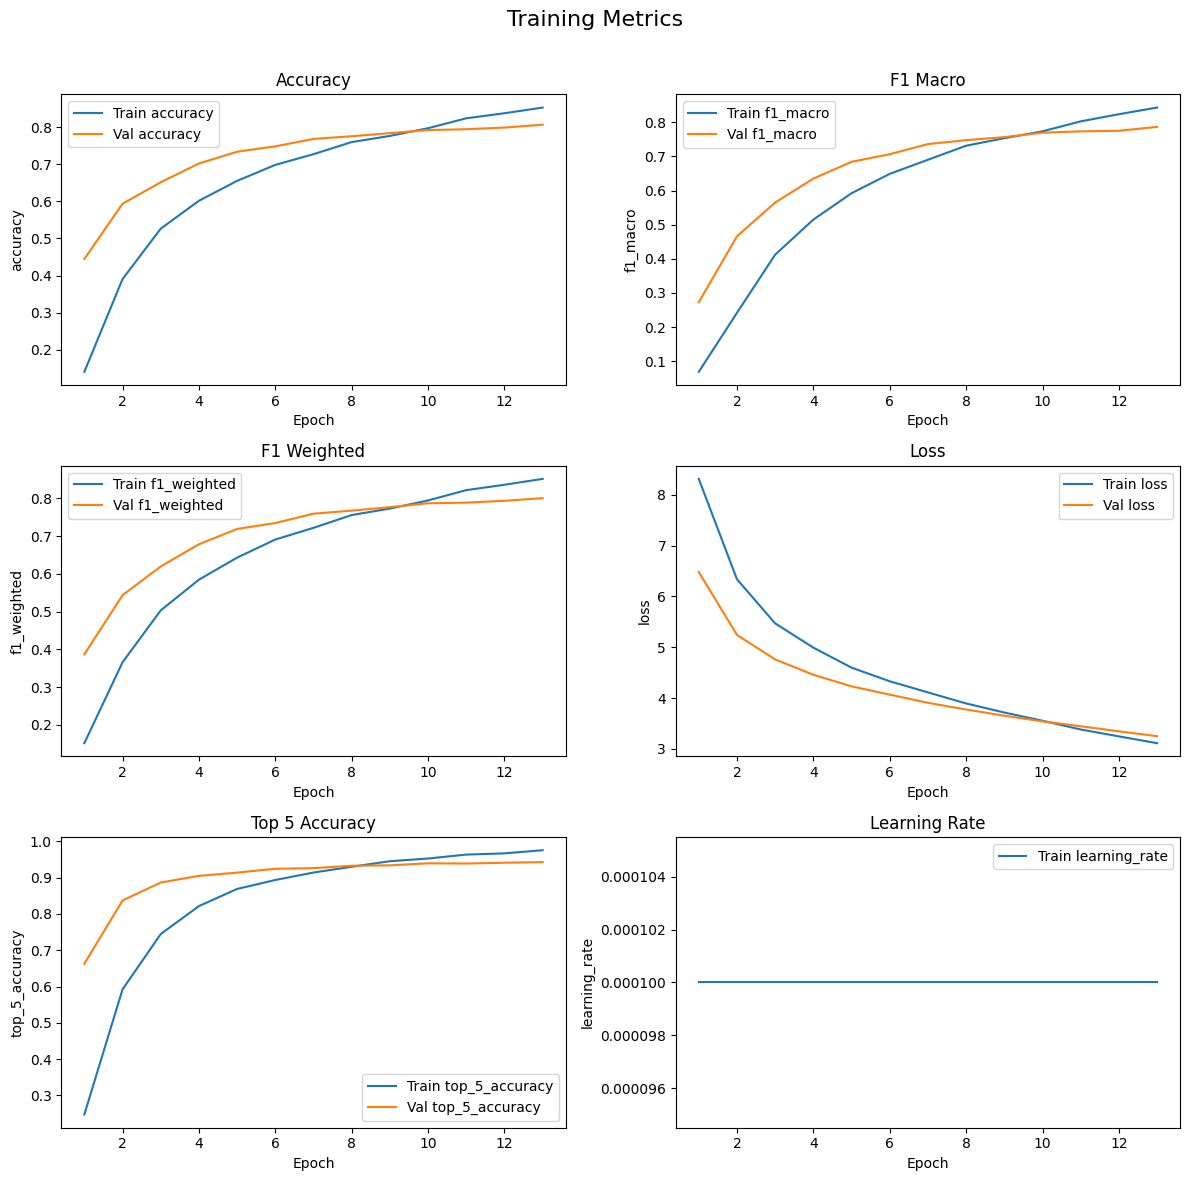

In [ ]:
plot_all_metrics(history_convnextfull)

#Accuracy: 0.84/0.81
#F1_Macro: 0.80/0.79
#F1_Weighted: 0.85/0.80

##### Loading the Model and analysing scores on test set

In [ ]:
convNext_best_model = load_model("/content/drive/MyDrive/dl_run/ConvNext/model_convnextfull_batch32.keras")

In [ ]:
y_true_test_convNext_best_model = []
y_pred_probs_test_convNext_best_model = []

for x_batch, y_batch in test_convnext:
    preds = convNext_best_model.predict(x_batch, verbose=0)
    y_pred_probs_test_convNext_best_model.append(preds)
    y_true_test_convNext_best_model.append(y_batch.numpy())

y_true_test_convNext_best_model = np.concatenate(y_true_test_convNext_best_model, axis=0)
y_pred_probs_test_convNext_best_model = np.concatenate(y_pred_probs_test_convNext_best_model, axis=0)

In [ ]:
acc_test = compute_accuracy(y_true_test_convNext_best_model, y_pred_probs_test_convNext_best_model)
f1_macro_test = compute_f1_macro(y_true_test_convNext_best_model, y_pred_probs_test_convNext_best_model)
f1_weighted_test = compute_f1_weighted(y_true_test_convNext_best_model, y_pred_probs_test_convNext_best_model)
top5_acc_test = compute_top5_accuracy(y_true_test_convNext_best_model, y_pred_probs_test_convNext_best_model)

print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test F1 Macro: {f1_macro_test:.4f}")
print(f"Test F1 Weighted: {f1_weighted_test:.4f}")
print(f"Test Top-5 Accuracy: {top5_acc_test:.4f}")

Test Accuracy: 0.8092
Test F1 Macro: 0.7855
Test F1 Weighted: 0.8024
Test Top-5 Accuracy: 0.9394


##### Analysing the worst predicted classes

10 worst predicted classes on test set


class_index                    family  f1_score  number_of_images_test
29            29   chordata_arthroleptidae  0.000000                      5
91            91       chordata_gymnuridae  0.000000                      5
190          190     cnidaria_helioporidae  0.000000                      5
57            57      chordata_chelydridae  0.285714                      4
79            79         chordata_emydidae  0.333333                      9
164          164        chordata_squalidae  0.333333                      5
134          134   chordata_podocnemididae  0.333333                      4
69            69       chordata_dalatiidae  0.333333                      4
149          149  chordata_rhinodermatidae  0.333333                      5
171          171     chordata_trionychidae  0.333333                      4

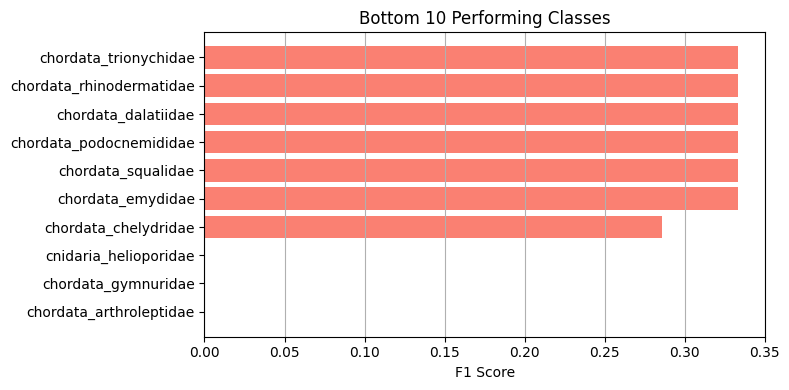

In [ ]:
y_true_labels = np.argmax(y_true_test_convNext_best_model, axis=1)
y_pred_labels = np.argmax(y_pred_probs_test_convNext_best_model, axis=1)

f1_per_class = f1_score(y_true_labels, y_pred_labels, average=None)

class_names = test.class_names

f1_df = pd.DataFrame({
    'class_index': np.arange(len(f1_per_class)),
    'family': class_names,
    'f1_score': f1_per_class
})

unique, counts = np.unique(y_true_labels, return_counts=True)
counts_dict = dict(zip(unique, counts))
f1_df['number_of_images_test'] = f1_df['class_index'].map(counts_dict)

worst_10 = f1_df.sort_values(by='f1_score', ascending=True).head(10)

print("10 worst predicted classes on test set")
display(worst_10)

plt.figure(figsize=(8, 4))
bars = plt.barh(worst_10['family'], worst_10['f1_score'], color='salmon')

plt.xlabel("F1 Score")
plt.title("Bottom 10 Performing Classes")
plt.grid(axis='x')
plt.tight_layout()
plt.show()



##### Hyperparameter Tuning with Random-Search

In [ ]:
best_model_callback= [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
         "best_model_ConvNext.keras",
         save_best_only=True,
         monitor="val_loss",
         verbose=1,
     ),
]

In [ ]:
class ConvNextHyperModel(HyperModel):
    def __init__(self, n_classes, input_shape=(224, 224, 3)):
        self.n_classes = n_classes
        self.input_shape = input_shape

    def build(self, hp):
        base_model = ConvNeXtBase(input_shape=self.input_shape, include_top=False, weights="imagenet")
        base_model.trainable = False

        inputs = Input(shape=self.input_shape)
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)

        # Tunable dense units and dropout
        x = Dense(
            units=hp.Choice("dense1_units", [512, 1024, 2048]),
            activation="gelu",
            kernel_regularizer=l2(hp.Float("l2_reg_2", 1e-3, 1e-1))
        )(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float("dropout1", 0.3, 0.6, step=0.1))(x)

        x = Dense(
            units=hp.Choice("dense2_units", [256, 512, 1024]),
            activation="gelu",
            kernel_regularizer=l2(hp.Float("l2_reg_dense2", 1e-3, 1e-1))
        )(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float("dropout2", 0.3, 0.6, step=0.1))(x)

        outputs = Dense(self.n_classes, activation="softmax")(x)

        model = Model(inputs, outputs)

        model.compile(
            optimizer=AdamW(
                learning_rate=hp.Float("lr", 1e-6, 1e-4),
                weight_decay=hp.Float("weight_decay", 3e-5, 3e-4)
            ),
            loss="categorical_crossentropy",
            metrics=["accuracy",
                     TopKCategoricalAccuracy(k=5, name="top_5_accuracy"),
                     F1Score(average='macro', name='f1_macro'),
                     F1Score(average='weighted', name='f1_weighted')]
        )

        return model

In [ ]:
tuner = RandomSearch(
    ConvNextHyperModel(n_classes=202),
    objective=Objective("val_f1_macro", direction="max"),
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory="tuner_logs",
    project_name="convnext_tuning"
)

tuner.search(train, validation_data=val, epochs=15, callbacks=best_model_callback)

Trial 20 Complete [00h 07m 11s]
val_f1_macro: 0.7743324041366577

Best val_f1_macro So Far: 0.7949770092964172
Total elapsed time: 02h 26m 03s


---

##### Hyperparameter Tuning

In [ ]:
convNext_random_search = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
trials = tuner.oracle.trials

trial_data = []
for trial_id, trial in trials.items():
    data = trial.hyperparameters.values.copy()
    data['val_f1_macro'] = trial.score
    data['trial_id'] = trial_id
    trial_data.append(data)

df_trials = pd.DataFrame(trial_data)

df_trials.sort_values(by="val_f1_macro", ascending=False)

dense1_units  l2_reg_2  dropout1  dense2_units  l2_reg_dense2  dropout2  \
13          2048  0.034871       0.5          1024       0.001125       0.3   
11           512  0.039219       0.5           512       0.004728       0.3   
5           2048  0.063969       0.4           512       0.091620       0.4   
15           512  0.034671       0.3          1024       0.091819       0.3   
10           512  0.040441       0.3           256       0.046370       0.3   
9           1024  0.024416       0.4           256       0.071620       0.4   
4           2048  0.007974       0.5          1024       0.083365       0.4   
17           512  0.018846       0.4           512       0.069633       0.5   
0           2048  0.058478       0.3           256       0.075352       0.3   
8           2048  0.089673       0.3           512       0.065415       0.3   
19          1024  0.062275       0.3           256       0.083699       0.3   
16          1024  0.087608       0.5           256       0.094021       0.4   
2            512  0.007898       0.5           512       0.027807       0.4   
1           2048  0.068733       0.3           256       0.050562       0.3   
12          1024  0.074438       0.5          1024       0.047028       0.5   
6           1024  0.021091       0.3          1024       0.039735       0.4   
14          1024  0.076252       0.4           512       0.007458       0.4   
7           1024  0.053022       0.5           256       0.093776       0.5   
18           512  0.027855       0.5          1024       0.016013       0.5   
3            512  0.060871       0.4           256       0.050934       0.3   

          lr  weight_decay  val_f1_macro trial_id  
13  0.000079      0.000278      0.794977       13  
11  0.000089      0.000066      0.792124       11  
5   0.000035      0.000071      0.791718       05  
15  0.000056      0.000097      0.788446       15  
10  0.000060      0.000274      0.787101       10  
9   0.000096      0.000167      0.786645       09  
4   0.000075      0.000297      0.783958       04  
17  0.000086      0.000245      0.783110       17  
0   0.000064      0.000271      0.779438       00  
8   0.000058      0.000188      0.775997       08  
19  0.000081      0.000171      0.774332       19  
16  0.000039      0.000266      0.771034       16  
2   0.000057      0.000127      0.751847       02  
1   0.000016      0.000178      0.749381       01  
12  0.000017      0.000194      0.682098       12  
6   0.000009      0.000271      0.614473       06  
14  0.000012      0.000137      0.538003       14  
7   0.000014      0.000281      0.465399       07  
18  0.000012      0.000210      0.449165       18  
3   0.000006      0.000170      0.213927       03

In [ ]:
df_trials.to_csv("/content/drive/MyDrive/dl_run/random_search_results.csv", index=False)

Although the best models obtained through Keras Tuner achieved validation metrics comparable to those of our manually constructed architectures (with val_f1_macro values reaching 0.79) we observed, during training, a significantly higher gap between training and validation performance. While this overfitting is not captured in the final df_trials DataFrame (which stores only validation scores), we closely monitored the training process and consistently found the tuned models to generalize worse than our baseline ConvNext variants. For this reason, we decided to continue with our manually designed models, which offer more stable performance and better generalization across different validation folds.

### <b style="background-color:#e35b89; padding:5px; border-radius:5px; display: inline-block;">Running Our Best Model on 90% Of The Data</b>


The dataset split was done in vscode, however the rest of the code was done in Colab by putting the zip folder in the drive

In [ ]:
# output_base = r"C:\Users\User\Desktop\deeplearning\dataset_split1"
# os.makedirs(output_base, exist_ok=True)
# for split in ['train', 'test']:
#     os.makedirs(os.path.join(output_base, split), exist_ok=True)

In [ ]:
# train_files, test_files = train_test_split(metadata, test_size=0.1, stratify=metadata['family'], random_state=42)

In [ ]:
# def move_files(file_subset, split_name):
#     for _, row in file_subset.iterrows():
#         src_path = os.path.join(dataset_directory, row['file_path'])  # Construct full path
#         dst_path = os.path.join(output_base, split_name, row['file_path'])
#         os.makedirs(os.path.dirname(dst_path), exist_ok=True)  # Ensure folder structure
#         if os.path.exists(src_path):
#             shutil.copy2(src_path, dst_path)
#         else:
#             print(f"Warning: {src_path} not found.")

# # Move images to respective folders
# move_files(train_files, 'train')
# move_files(test_files, 'test')

In [ ]:
!unzip "/content/drive/MyDrive/dataset_split1.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset_split1/train/chordata_iguanidae/29983200_47044557_eol-full-size-copy.jpg  
  inflating: /content/dataset_split1/train/chordata_iguanidae/29983201_47044557_eol-full-size-copy.jpg  
  inflating: /content/dataset_split1/train/chordata_iguanidae/29983203_47044557_eol-full-size-copy.jpg  
  inflating: /content/dataset_split1/train/chordata_iguanidae/29983206_47044557_eol-full-size-copy.jpg  
  inflating: /content/dataset_split1/train/chordata_iguanidae/29983207_47044557_eol-full-size-copy.jpg  
  inflating: /content/dataset_split1/train/chordata_iguanidae/29983209_47044557_eol-full-size-copy.jpg  
  inflating: /content/dataset_split1/train/chordata_iguanidae/29983216_47044557_eol-full-size-copy.jpg  
  inflating: /content/dataset_split1/train/chordata_iguanidae/8890761_454868_eol-full-size-copy.jpg  
  inflating: /content/dataset_split1/train/chordata_iguanidae/8890762_454868_eol-full-size-copy.jpg  
  inflatin

In [ ]:
train_path_big_split = "/content/dataset_split1/train"
test_path_big_split = "/content/dataset_split1/test"

In [ ]:
train_big_split = tf.keras.utils.image_dataset_from_directory(
    directory=train_path_big_split,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42
)

test_big_split = tf.keras.utils.image_dataset_from_directory(
    directory=test_path_big_split,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=42
)

Found 10784 files belonging to 202 classes.
Found 1199 files belonging to 202 classes.


In [ ]:
def ConvNextFull(n_classes, train_dataset, val_dataset, epochs=13, callbacks=None):

    base_model = ConvNeXtBase(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
    base_model.trainable = False

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024, activation="gelu", kernel_regularizer=l2(0.002))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, activation="gelu", kernel_regularizer=l2(0.002))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(n_classes, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=AdamW(1e-4, weight_decay=3e-4), loss="categorical_crossentropy", metrics=['accuracy',
                TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
                F1Score(average='macro', name='f1_macro'),
                F1Score(average='weighted', name='f1_weighted')])

    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=callbacks)

    return model, history

In [36]:
model_convnextfull_batch32, history_convnextfull_batch32 = ConvNextFull(202, train_big_split, test_big_split, epochs=15, callbacks=best_model_callback)

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step
Epoch 1/15
337/337 ━━━━━━━━━━━━━━━━━━━━ 168s 420ms/step - accuracy: 0.0907 - f1_macro: 0.0413 - f1_weighted: 0.1000 - loss: 8.8724 - top_5_accuracy: 0.1721 - val_accuracy: 0.5254 - val_f1_macro: 0.3525 - val_f1_weighted: 0.4637 - val_loss: 5.9176 - val_top_5_accuracy: 0.7481 - learning_rate: 1.0000e-04
Epoch 2/15
337/337 ━━━━━━━━━━━━━━━━━━━━ 130s 383ms/step - accuracy: 0.4212 - f1_macro: 0.2601 - f1_weighted: 0.3947 - loss: 6.1619 - top_5_accuracy: 0.6308 - val_accuracy: 0.6405 - val_f1_macro: 0.5225 - val_f1_weighted: 0.6004 - val_loss: 4.8700 - val_top_5_accuracy: 0.8749 - learning_rate: 1.0000e-04
Epoch 3/15
337/337 ━━━━━━━━━━━━━━━━━━━━ 130s 384ms/step - accuracy: 0.5550 - f1_macro: 0.4253 - f1_weighted: 0.5336 - loss: 5.2704 - top_5_accuracy: 0.7775 - val_accuracy: 0.7073 - val_f1_macro: 0.6208 - val_f1_weighted: 0.6759 - val_loss: 4.4399 - val_top_5_accuracy: 0.8991 - learning_rate: 1.0000e-04
Epoch 4/15
337/337 ━━━━━━━━━━━━━━━

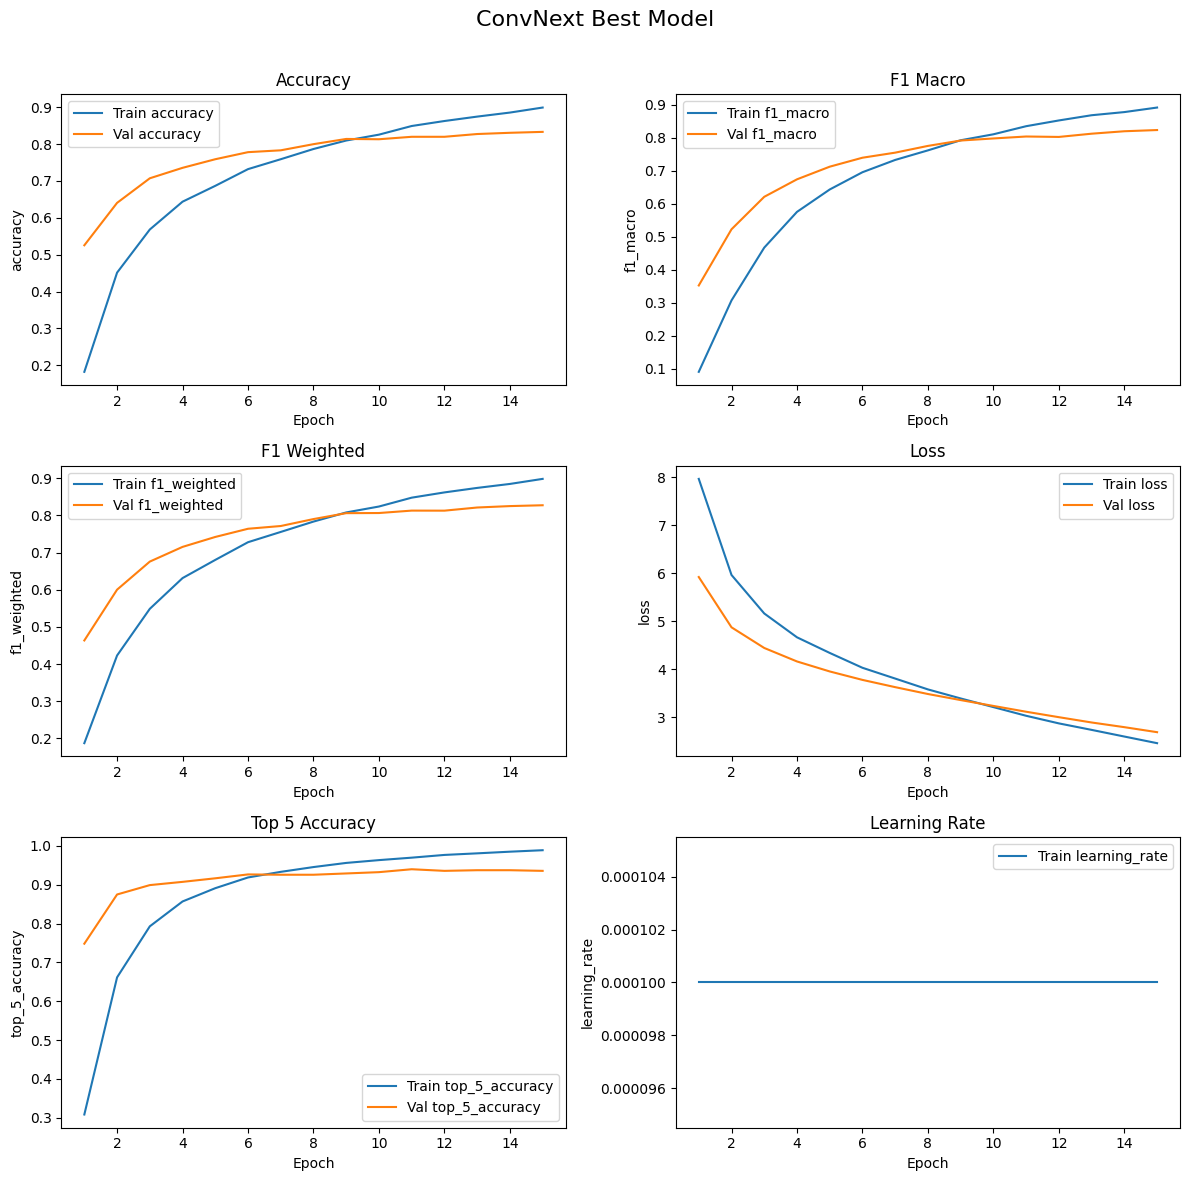

In [37]:
plot_all_metrics(history_convnextfull_batch32, title="ConvNext Best Model")

In [39]:
y_true_val = []
y_pred_probs_val = []

for x_batch, y_batch in test_big_split:
    preds = model_convnextfull_batch32.predict(x_batch, verbose=0)
    y_pred_probs_val.append(preds)
    y_true_val.append(y_batch.numpy())

y_true_val = np.concatenate(y_true_val, axis=0)
y_pred_probs_val = np.concatenate(y_pred_probs_val, axis=0)

y_true_labels_val = np.argmax(y_true_val, axis=1)
y_pred_labels_val = np.argmax(y_pred_probs_val, axis=1)

#### 10 worst predicted classes on validation set

10 worst predicted classes on validation set


class_index                     family  f1_score  number_of_images_val
190          190      cnidaria_helioporidae  0.000000                     3
186          186   cnidaria_diploastraeidae  0.285714                     3
193          193       cnidaria_merulinidae  0.285714                     6
31            31  chordata_balaenicipitidae  0.400000                     3
130          130    chordata_phyllostomidae  0.400000                     3
44            44     chordata_caprimulgidae  0.400000                     3
56            56       chordata_cheloniidae  0.400000                     3
185          185  cnidaria_dendrophylliidae  0.400000                     3
128          128   chordata_phrynosomatidae  0.500000                     3
129          129   chordata_phyllomedusidae  0.500000                     3

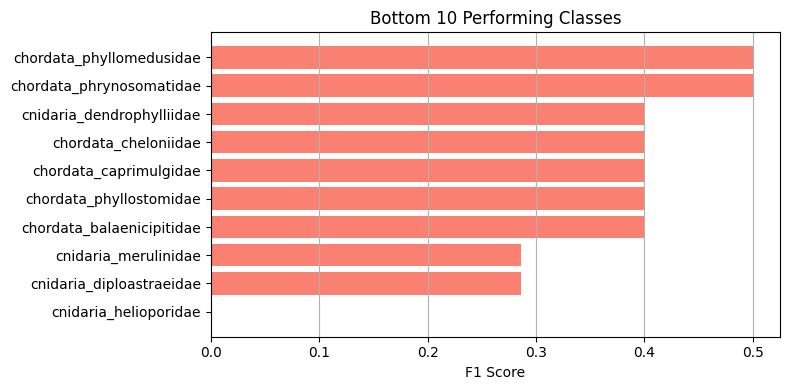

In [40]:
f1_per_class_val = f1_score(y_true_labels_val, y_pred_labels_val, average=None)

class_names = test_big_split.class_names

f1_df_val = pd.DataFrame({
    'class_index': np.arange(len(f1_per_class_val)),
    'family': class_names,
    'f1_score': f1_per_class_val
})

unique_val, counts_val = np.unique(y_true_labels_val, return_counts=True)
counts_dict_val = dict(zip(unique_val, counts_val))
f1_df_val['number_of_images_val'] = f1_df_val['class_index'].map(counts_dict_val)

worst_10_val = f1_df_val.sort_values(by='f1_score', ascending=True).head(10)

print("10 worst predicted classes on validation set")
display(worst_10_val)

plt.figure(figsize=(8, 4))
bars = plt.barh(worst_10_val['family'], worst_10_val['f1_score'], color='salmon')

plt.xlabel("F1 Score")
plt.title("Bottom 10 Performing Classes")
plt.grid(axis='x')
plt.tight_layout()
plt.show()
